# Introduction
The following analysis aims at building a machine learning model to predict cross sell success of Apprentice Chef customers to the wine delivery service Halfway there

# Importing all necessary packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random as rand
import statsmodels.formula.api as smf
import sklearn.linear_model
import pydotplus
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz       
from sklearn.externals.six import StringIO     
from IPython.display import Image              
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import make_scorer


C:\Users\Georg\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


# Importing Dataset

In [2]:
# importing data set

original_df = pd.read_excel('C:/Users/Georg/Desktop/Hult/MSBA/Machine Learning/Case/Apprentice_Chef_Dataset.xlsx')

# making a copy and shorter name to protect original_df

df=original_df.copy()

# lower casing for easier working
df.columns = map(str.lower, df.columns)

# adjusting display options and setting pandas print options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 200)


# Initial Data Exploration

In [3]:
# Creating a missing values column.
# looping over columns with missing values
for col in df:

    # creating columns with 1s if missing and 0 if not
    if df[col].isnull().astype(int).sum() > 0:
        df['m_'+col] = df[col].isnull().astype(int)
        
# cleaning trailing spaces in family_names
df['family_name'] = df['family_name'].str.strip()

# there is one largest_order_size = 0, which doesn't make sense with positive revenue
# replace it with 1
df['largest_order_size']= df['largest_order_size'].replace(0, 1 )


In [4]:
# looking at quantiles
# the quantile below 1285 revenue has low cross sell success
# we will mark this as an outlier
# df.loc[:, :].quantile([0.20,
#                            0.40,
#                            0.60,
#                            0.80,
#                            1.00])

In [5]:
#looking at correlations
#df.corr()
#df_corr = df.corr().round(2)
#print(df_corr.loc['cross_sell_success'].sort_values(ascending = False))
#print(df_corr.loc['followed_recommendations_pct'].sort_values(ascending = False))


Initial data exploration showed a relatively clean dataset.
The only missing values are in family names, for which we created a missing value column, but didn't fill them yet.
There are some trailing spaces in family_name which we removed.
One value of 0 in largest_order_size was replaced witch 1, since 0 is not possible for positive revenue.
Looking at the quantiles showed low cross sell success (css) in the first quantile.
We will mark this as an outlier. 
Correlations with css in general seem to be surprisingly low, except for followed_recommendations.
Unfortunately, followed_recommendations also has mostly low recommendations.

# Feature engineering

## Feature engineering based on general domain knowledge

In [6]:
# calculating if they bought any beverages.

# from the case description, max price per meal is $23
# so every order above must include drinks
# max non alcoholic drink price is $5
# so every order above $28 must include wine
# also, we will try to factor in reductions for weekly plans
# added safeguard for new customers without revenue

df['avg_spend'] = df['revenue']/df['total_meals_ordered']
avg_spend_change_hi = 23
df['beverages'] = 0
condition = df.loc[0:,'beverages'][df['avg_spend'] > avg_spend_change_hi]
condition_0 = df.loc[0:,'beverages'][df['avg_spend'] == 0]

df['beverages'].replace(to_replace = condition,
                                      value      = 1,
                                      inplace    = True)
df['beverages'].replace(to_replace = condition_0,
                                      value      = 0,
                                      inplace    = True)

avg_spend_change_alc = 28
df['alcohol'] = 0
condition = df.loc[0:,'alcohol'][df['avg_spend'] > avg_spend_change_alc]
condition_0 = df.loc[0:,'alcohol'][df['avg_spend'] == 0]

df['alcohol'].replace(to_replace = condition,
                                      value      = 1,
                                      inplace    = True)
df['alcohol'].replace(to_replace = condition_0,
                                      value      = 0,
                                      inplace    = True)

# maximum average spend should be $23+25=48
# but some averages are much higher. Investigate further
# total meals ordered seems to be really number of total orders

# adding complaints as a percentage of total meals ordered
df['perc_complaints'] = df['contacts_w_customer_service']/df['total_meals_ordered']

# adding tendency to try new meals
df['new_meal_tendency'] = df['unique_meals_purch']/df['total_meals_ordered']

# adding perc of meals ordered as part of a meal plan, assuming an average 4 meals per plan
df['perc_meal_plan'] = df['weekly_plan']*4/df['total_meals_ordered']

# adding cancelations percentage of total orders
# busy customers could have different cross sell habits
df['perc_cancelations_before_noon'] = df['cancellations_before_noon']/df['total_meals_ordered']
df['perc_cancelations_after_noon'] = df['cancellations_after_noon']/df['total_meals_ordered']

#adding total_meals_ordered *followed_recommendations_pct/100
#shows how many orders where completed as recommendations
df['recommended_meals'] = df['total_meals_ordered']*df['followed_recommendations_pct']/100

# adding clicks_per_time
# this could estimate the activity while being on the website
df['clicks_per_time'] = df['avg_clicks_per_visit']/df['avg_time_per_site_visit']

#adding contacts_w_customer_service - early_deliveries -late_deliveries
#complaints would often be about the timing of the food
#complaints when the food was on time suggests other issues
df['on_time_complaints'] = df['contacts_w_customer_service']-df['early_deliveries']-df['late_deliveries']

# adding unique_meals_purch/product_categories_viewed
# this could be a proxy for curiosity
df['cat_viewed_purchased'] = df['unique_meals_purch']/df['product_categories_viewed']

# adding avg_time_per_site_visit/product_categories_viewed
# could show how quickly people decide
df['time_per_category'] = df['avg_time_per_site_visit']/df['product_categories_viewed']

#adding revenue/avg_time_per_site_visit
df['revenue_per_time'] = df['revenue']/df['avg_time_per_site_visit']

#adding revenue/avg_clicks_per_visit
df['revenue_per_click'] = df['revenue']/df['avg_clicks_per_visit']

#adding total cancelations
df['total_cancelations'] = df['cancellations_after_noon']+df['cancellations_before_noon']

#adding total_photos_viewed/avg_time_per_site_visit
df['photos_per_time'] = df['total_photos_viewed']/df['avg_time_per_site_visit']

#adding avg_time_per_site_visit + avg_prep_vid_time
#could proxy engagement 
df['total_time'] = df['avg_time_per_site_visit']+df['avg_prep_vid_time']

#adding largest_order_size*total_meals_ordered
#since we are not sure if total_meals_ordered is meals or orders, this is the maximum meals ordered
df['max_potential_meals'] = df['largest_order_size']*df['total_meals_ordered']

#adding total_meals_ordered/largest_order_size
#if it is number of meals, this is the minimum amount of orders
df['min_potential_orders'] = df['total_meals_ordered']/df['largest_order_size']

#adding revenue + avg_spend*cancellations_before_noon + avg_spend*cancellations_after_noon*0.5
#adjusting revenue for cancelations
df['adjusted_revenue'] = df['revenue']+df['avg_spend']*df['cancellations_before_noon']+ df['avg_spend']*df['cancellations_after_noon']*0.5

#adding mobile_logins + pc_logins
df['total_logins'] = df['mobile_logins']+df['pc_logins']

#adding followed_recommendations_pct*median_meal_rating
#could proxy satisfaction with recommendations
df['recommendations_satisfaction'] = df['followed_recommendations_pct']*df['median_meal_rating']

#adding followed_recommendations_pct/contacts_w_customer_service
df['complaints_on_recommendations'] = df['followed_recommendations_pct']/df['contacts_w_customer_service']


## Feature engineering based on Information from Customer Service

Based on the segmentation of email domains by the Customer service department, it is possible to customer segmentation based on their email addresses.

In [7]:
# creating columns for email categorization

# Splitting emails to categorise them

# STEP 1: splitting personal emails

# placeholder list
placeholder_lst = []

# looping over each email address
for index, col in df.iterrows():
    
    # splitting email domain at '@'
    split_email = df.loc[index, 'email'].split(sep = '@')
    
    # appending placeholder_lst with the results
    placeholder_lst.append(split_email)
    

# converting placeholder_lst into a DataFrame 
email_df = pd.DataFrame(placeholder_lst)


# STEP 2: concatenating with original DataFrame

# renaming column to concatenate
email_df.columns = ['0' , 'email_domain']


# concatenating email_domain with df DataFrame
df = pd.concat([df, email_df['email_domain']],
                     axis = 1)

# aggreate emails

# email domain types
personal_email_domains = [  '@gmail.com',
                            '@yahoo.com',
                            '@protonmail.com']
professional_email_domains = ['@mmm.com',
                            '@amex.com',
                            '@apple.com',
                            '@boeing.com',
                            '@caterpillar.com',
                            '@chevron.com',
                            '@cisco.com',
                            '@cocacola.com',
                            '@disney.com',
                            '@dupont.com',
                            '@exxon.com',
                            '@ge.org',
                            '@goldmansacs.com',
                            '@homedepot.com',
                            '@ibm.com',
                            '@intel.com',
                            '@jnj.com',
                            '@jpmorgan.com',
                            '@mcdonalds.com',
                            '@merck.com',
                            '@microsoft.com',
                            '@nike.com',
                            '@pfizer.com',
                            '@pg.com',
                            '@travelers.com',
                            '@unitedtech.com',
                            '@unitedhealth.com',
                            '@verizon.com',
                            '@visa.com',
                            '@walmart.com']

junk_email_domains  = [     '@me.com',
                            '@aol.com',
                            '@hotmail.com',
                            '@live.com',
                            '@msn.com',
                            '@passport.com']


# placeholder list
placeholder_lst = []


# looping to group observations by domain type
for domain in df['email_domain']:
    
    if '@' + domain in personal_email_domains:
        placeholder_lst.append('personal')
        

    elif '@' + domain in professional_email_domains:
        placeholder_lst.append('professional')
        
        
    elif '@' + domain in junk_email_domains:
        placeholder_lst.append('junk')


    else:
            print('Unknown')


# concatenating with original DataFrame
df['domain_group'] = pd.Series(placeholder_lst)

# creating dummy variables for email domain groups
one_hot_domain_group = pd.get_dummies(df['domain_group'])

# joining codings together
df = df.join([one_hot_domain_group])

## Feature engineering based on Client names

Some clients have the same first and last name. It is possible that these names are in truth missing, and family names are just filled with first names. This could indicate missing ID verification, which would prevent them from buying alcohol. Accordingly, customers with the same names have a negative correlation with cross sell success. It would also be possible, that these names in the context of game of thrones suggest a lower social status and spending power. However, the extremely weak correlation of of dif_names with revenue indicates that this is not the case.

In [8]:
# adding column for where first and last names are the same

df['dif_names'] = 0
condition = df.loc[0:,'first_name'] == df.loc[0:,'family_name']

df['dif_names'].replace(to_replace = condition,
                                value      = 1,
                                inplace    = True)

df['same_names'] = 0
names_placeholder_lst=[]
for i in df['dif_names']:
    
    if i == 0:
        names_placeholder_lst.append(1)
    else:
        names_placeholder_lst.append(0)
        
df['same_names'] = pd.Series(names_placeholder_lst)
        
# print(df['same_names'].value_counts())


After exploring different names in the next segment, it seems that clients with family names appearing more than four times in the client base seem to be more prone to cross sell success. The multiple appearance could either be chance, or could indicate family ties between these customers. Higher css in families could either indicate that they drink wine in social groups together, or it could indicate a significant impact of word of mouth and positive recommendations by trusted peers.
This could be a good lever for marketing and deserves further investigation.

In [9]:
#exploring if names are related to trends

#print(df['family_name'].value_counts())
df_names=df[['family_name', 'cross_sell_success']].groupby('family_name').describe().reset_index()
df_names2=df_names.sort_values(by=('cross_sell_success','count'), ascending=False)
#df_names2.head(300)
#df.describe()
#The mean in the full data set 0.678. 
#So if a name is above that, it is more likely to cross sell.
#For the frequent family names, the mean of cross_sell_success is mostly higher
#This means, bigger families seem to be more likely to cross sell

In [10]:
#preparing names for list
#for val in df_names2['family_name'].head(300):
#    print(f"'{val}',")

In [11]:
#creating a dummy for families of at least four members

family_list= ['Frey',
'Targaryen',
'Stark',
'Tyrell',
'Lannister',
'Hightower',
'Greyjoy',
'Florent',
'Vance',
'Botley',
'Royce',
'Rivers',
'Martell',
'Crakehall',
'Harlaw',
'Arryn',
'Baratheon',
'Bracken',
'Sand',
'Waynwood',
'Velaryon',
'Seaworth',
'Westerling',
'Flowers',
'Plumm',
'Redwyne',
'Karstark',
'Fossoway',
'Osgrey',
'Brax',
'Mormont',
'Swann',
'I Targaryen',
'Wylde',
'Paege',
'Drumm',
'Goodbrother',
'Tallhart',
'zo Loraq',
'Beesbury',
'Mallister',
'Manderly',
'Glover',
'Umber',
'Estermont',
'Swyft',
'Dayne',
'Darry',
'Caswell',
'Farwynd',
'Norcross',
'Redfort',
'Blackwood',
'Heddle',
'Flint',
'II Targaryen',
'Hollard',
'Crane',
'Whent',
'Ryswell',
'Oakheart',
'Tully',
'Haigh',
'Crabb',
'Hornwood',
'Ambrose',
'Smallwood',
'Pyke',
'Connington',
'Ironmaker',
'Cassel',
'Lothston',
'Tarly',
'Hunter',
'Strong',
'Kettleblack',
'Slynt',
'Hill',
'Stokeworth',
'Storm',
'Caron',
'Yronwood',
'Farring',
'Manwoody',
'Goodbrook',
'III Targaryen', # manual cleanup of impurities in the dataset
'IV Targaryen',  # manual cleanup of impurities in the dataset
'V Targaryen',   # manual cleanup of impurities in the dataset
'Corbray']

df['family'] = 0
family_placeholder_lst=[]
for name in df['family_name']:
    
    if name in family_list:
        family_placeholder_lst.append(1)
    else:
        family_placeholder_lst.append(0)
        
df['family'] = pd.Series(family_placeholder_lst)
        
#print(df['family'].value_counts())

In [12]:
#creating a dummy for unique family names
family1_list=['Frey',
'Targaryen',
'Stark',
'Tyrell',
'Lannister',
'Hightower',
'Greyjoy',
'Florent',
'Vance',
'Botley',
'Royce',
'Rivers',
'Martell',
'Crakehall',
'Harlaw',
'Arryn',
'Baratheon',
'Bracken',
'Sand',
'Waynwood',
'Velaryon',
'Seaworth',
'Westerling',
'Flowers',
'Plumm',
'Redwyne',
'Karstark',
'Fossoway',
'Osgrey',
'Brax',
'Mormont',
'Swann',
'I Targaryen',
'Wylde',
'Paege',
'Drumm',
'Goodbrother',
'Tallhart',
'zo Loraq',
'Beesbury',
'Mallister',
'Manderly',
'Glover',
'Umber',
'Estermont',
'Swyft',
'Dayne',
'Darry',
'Caswell',
'Farwynd',
'Norcross',
'Redfort',
'Blackwood',
'Heddle',
'Flint',
'II Targaryen',
'Hollard',
'Crane',
'Whent',
'Ryswell',
'Oakheart',
'Tully',
'Haigh',
'Crabb',
'Hornwood',
'Ambrose',
'Smallwood',
'Pyke',
'Connington',
'Ironmaker',
'Cassel',
'Lothston',
'Tarly',
'Hunter',
'Strong',
'Kettleblack',
'Slynt',
'Hill',
'Stokeworth',
'Storm',
'Caron',
'Yronwood',
'Farring',
'Manwoody',
'Goodbrook',
'Corbray',
'Stackspear',
'Bulwer',
'Spicer',
'Penrose',
'Waters',
'Lefford',
'Staunton',
'Vypren',
'Stone',
'Hoare',
'Payne',
'Kenning',
'Penny',
'Piper',
'Uller',
'Stout',
'Darklyn',
'Qorgyle',
'Terys',
'Brune',
'Costayne',
'Locke',
'Bolton',
'Mooton',
'Santagar',
'Rowan',
'Morrigen',
'Ashford',
'of Oldtown',
'Grafton',
'Reed',
'Marbrand',
'Hardyng',
'Sharp',
'Blackmont',
'Webber',
'Willum',
'Snow',
'Alyn',
'Toyne',
'Meadows',
'Dalt',
'Jordayne',
'Rosby',
'Poole',
'Cuy',
'Uffering',
'Boy',
'of Pennytree',
'Wells',
'Hewett',
'Mullendore',
'Rykker',
'Selmy',
'Henly',
'Greenfield',
'Prestayn',
'Hetherspoon',
'Dothare',
'zo Galare',
'Dustin',
'Tarth',
'Mo',
'Ryger',
'Thorne',
'Inchfield',
'Hunt',
'Prester',
'Dondarrion',
'Humble',
'Allyrion',
'Tollett',
'Dick',
'Jeyne',
'Lonmouth',
'Serry',
'Rolfe',
'Lydden',
'Bernarr',
'Clifton',
'Lorch',
'Clegane',
'Blacktyde',
'Shepherd',
'Fell',
'Lynderly',
'Vaith',
'Norrey',
'Cerwyn',
'Nayland',
'Blackfyre',
'Charlton',
'Otherys',
'Wythers',
'Blackberry',
'Codd',
'Peake',
'Belmore',
'Ben',
'Woodwright',
'Wull',
'Knight',
'Wynch',
'King']

df['unique_name'] = 0
family1_placeholder_lst=[]
for name in df['family_name']:
    
    if name in family1_list:
        family1_placeholder_lst.append(0)
    else:
        family1_placeholder_lst.append(1)
        
df['unique_name'] = pd.Series(family1_placeholder_lst)
        
#print(df['unique_name'].value_counts())

In [13]:
#creating a dummy for family names that appear exactly twice
# this will help to spot a potential trend change from 1 to 2

family2_list=[
'Alyn',
'Toyne',
'Meadows',
'Dalt',
'Jordayne',
'Rosby',
'Poole',
'Cuy',
'Uffering',
'Boy',
'of Pennytree',
'Wells',
'Hewett',
'Mullendore',
'Rykker',
'Selmy',
'Henly',
'Greenfield',
'Prestayn',
'Hetherspoon',
'Dothare',
'zo Galare',
'Dustin',
'Tarth',
'Mo',
'Ryger',
'Thorne',
'Inchfield',
'Hunt',
'Prester',
'Dondarrion',
'Humble',
'Allyrion',
'Tollett',
'Dick',
'Jeyne',
'Lonmouth',
'Serry',
'Rolfe',
'Lydden',
'Bernarr',
'Clifton',
'Lorch',
'Clegane',
'Blacktyde',
'Shepherd',
'Fell',
'Lynderly',
'Vaith',
'Norrey',
'Cerwyn',
'Nayland',
'Blackfyre',
'Charlton',
'Otherys',
'Wythers',
'Blackberry',
'Codd',
'Peake',
'Belmore',
'Ben',
'Woodwright',
'Wull',
'Knight',
'Wynch',
'King']

df['name_twice'] = 0
family2_placeholder_lst=[]
for name in df['family_name']:
    
    if name in family2_list:
        family2_placeholder_lst.append(1)
    else:
        family2_placeholder_lst.append(0)
        
df['name_twice'] = pd.Series(family2_placeholder_lst)
        
#print(df['name_twice'].value_counts())

## Feature engineering by analyzing outliers

### Plotting histograms to spot outliers

Index(['revenue', 'cross_sell_success', 'name', 'email', 'first_name', 'family_name', 'total_meals_ordered', 'unique_meals_purch', 'contacts_w_customer_service', 'product_categories_viewed', 'avg_time_per_site_visit', 'mobile_number', 'cancellations_before_noon', 'cancellations_after_noon', 'tastes_and_preferences', 'mobile_logins', 'pc_logins', 'weekly_plan', 'early_deliveries', 'late_deliveries', 'package_locker', 'refrigerated_locker', 'followed_recommendations_pct', 'avg_prep_vid_time', 'largest_order_size', 'master_classes_attended', 'median_meal_rating', 'avg_clicks_per_visit', 'total_photos_viewed', 'm_family_name', 'avg_spend', 'beverages', 'alcohol', 'perc_complaints', 'new_meal_tendency', 'perc_meal_plan', 'perc_cancelations_before_noon', 'perc_cancelations_after_noon', 'recommended_meals', 'clicks_per_time', 'on_time_complaints', 'cat_viewed_purchased', 'time_per_category', 'revenue_per_time', 'revenue_per_click', 'total_cancelations', 'photos_per_time', 'total_time',
      

Text(0.5, 0, 'perc_cancelations_after_noon')

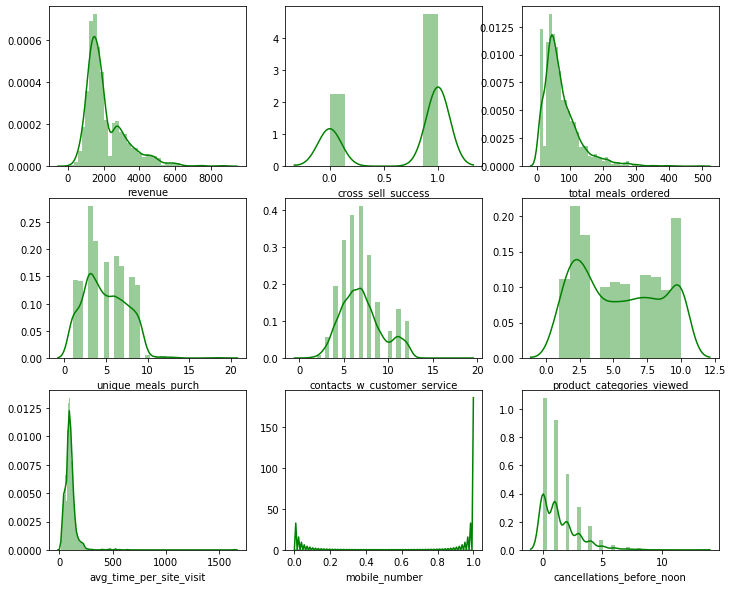

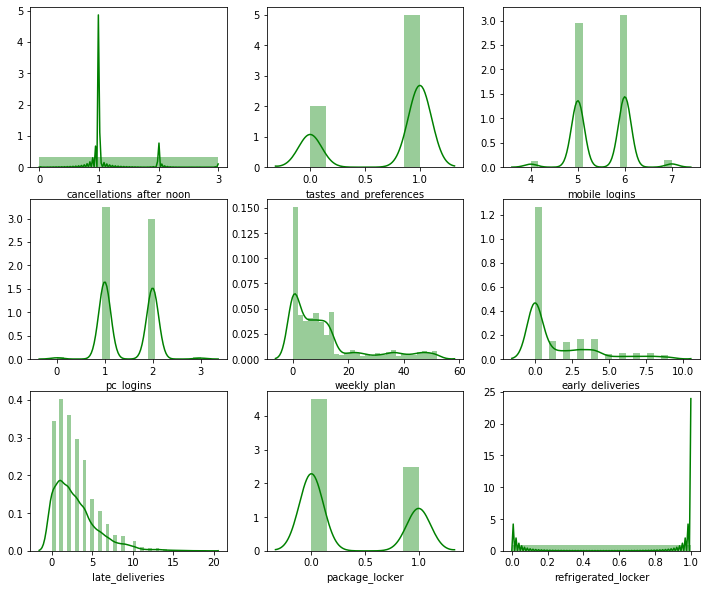

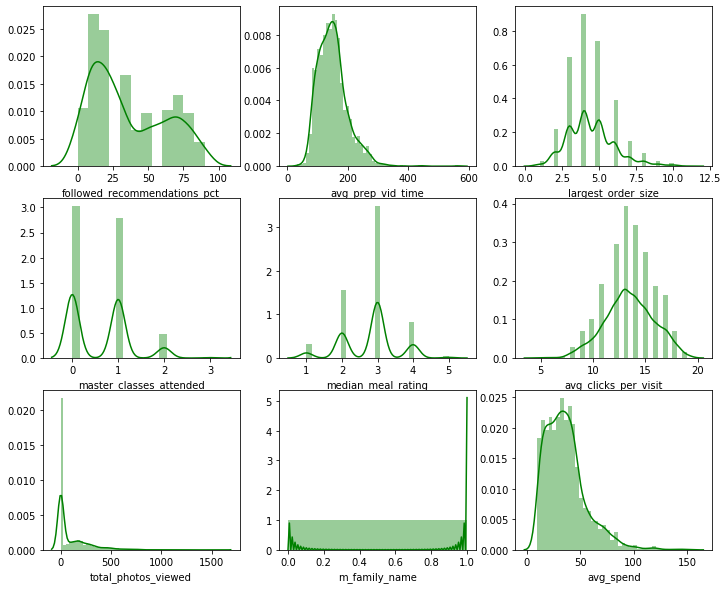

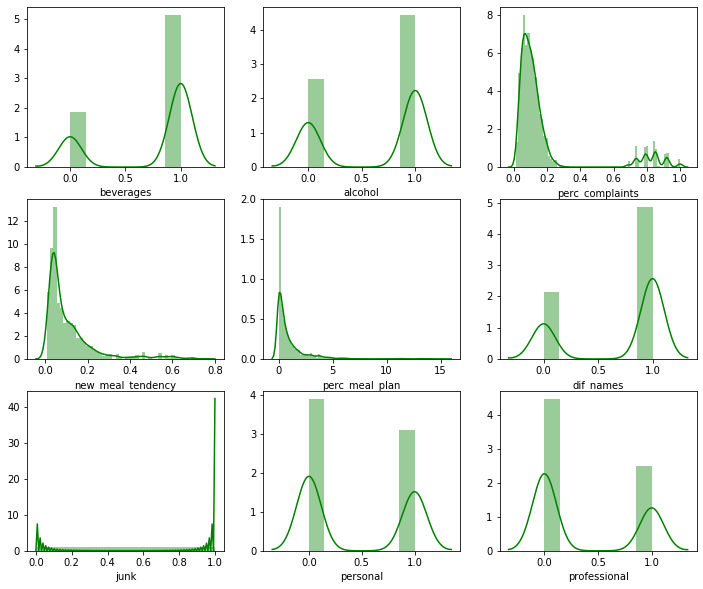

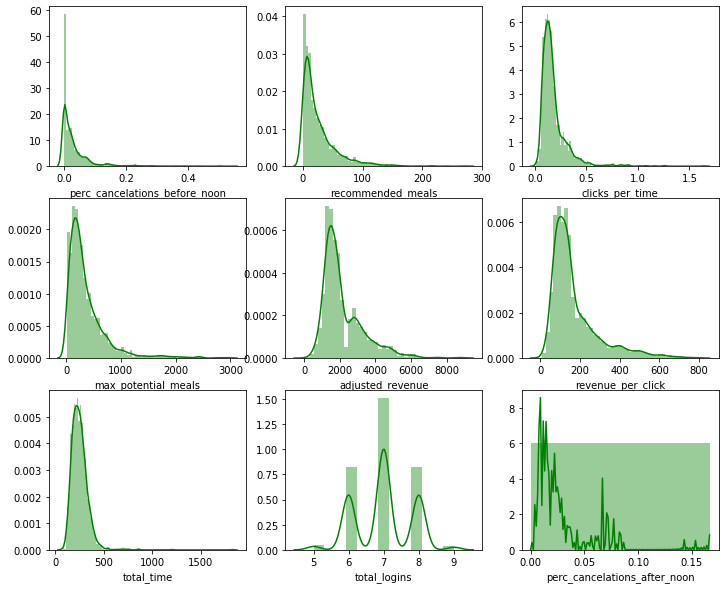

In [14]:
#outlier analysis
print(df.columns)

#Histograms
fig, ax = plt.subplots(figsize = (12, 10))
plt.subplot(3, 3, 1)
sns.distplot(df['revenue'],
             bins  = 'fd',
             color = 'g')
plt.xlabel('revenue')

plt.subplot(3, 3, 2)
sns.distplot(df['cross_sell_success'],
             bins  = 'fd',
             color = 'g')
plt.xlabel('cross_sell_success')

plt.subplot(3, 3, 3)
sns.distplot(df['total_meals_ordered'],
             bins  = 'fd',
             color = 'g')
plt.xlabel('total_meals_ordered')

plt.subplot(3, 3, 4)
sns.distplot(df['unique_meals_purch'],
             bins  = 'fd',
             color = 'g')
plt.xlabel('unique_meals_purch')

plt.subplot(3, 3, 5)
sns.distplot(df['contacts_w_customer_service'],
             bins  = 'fd',
             color = 'g')
plt.xlabel('contacts_w_customer_service')

plt.subplot(3, 3, 6)
sns.distplot(df['product_categories_viewed'],
             bins  = 'fd',
             color = 'g')
plt.xlabel('product_categories_viewed')

plt.subplot(3, 3, 7)
sns.distplot(df['avg_time_per_site_visit'],
             bins  = 'fd',
             color = 'g')
plt.xlabel('avg_time_per_site_visit')

plt.subplot(3, 3, 8)
sns.distplot(df['mobile_number'],
             bins  = 'fd',
             color = 'g')
plt.xlabel('mobile_number')

plt.subplot(3, 3, 9)
sns.distplot(df['cancellations_before_noon'],
             bins  = 'fd',
             color = 'g')
plt.xlabel('cancellations_before_noon')

########################

fig, ax = plt.subplots(figsize = (12, 10))
plt.subplot(3, 3, 1)
sns.distplot(df['cancellations_after_noon'],
             bins  = 'fd',
             color = 'g')
plt.xlabel('cancellations_after_noon')

plt.subplot(3, 3, 2)
sns.distplot(df['tastes_and_preferences'],
             bins  = 'fd',
             color = 'g')
plt.xlabel('tastes_and_preferences')

plt.subplot(3, 3, 3)
sns.distplot(df['mobile_logins'],
             bins  = 'fd',
             color = 'g')
plt.xlabel('mobile_logins')

plt.subplot(3, 3, 4)
sns.distplot(df['pc_logins'],
             bins  = 'fd',
             color = 'g')
plt.xlabel('pc_logins')

plt.subplot(3, 3, 5)
sns.distplot(df['weekly_plan'],
             bins  = 'fd',
             color = 'g')
plt.xlabel('weekly_plan')

plt.subplot(3, 3, 6)
sns.distplot(df['early_deliveries'],
             bins  = 'fd',
             color = 'g')
plt.xlabel('early_deliveries')

plt.subplot(3, 3, 7)
sns.distplot(df['late_deliveries'],
             bins  = 'fd',
             color = 'g')
plt.xlabel('late_deliveries')

plt.subplot(3, 3, 8)
sns.distplot(df['package_locker'],
             bins  = 'fd',
             color = 'g')
plt.xlabel('package_locker')

plt.subplot(3, 3, 9)
sns.distplot(df['refrigerated_locker'],
             bins  = 'fd',
             color = 'g')
plt.xlabel('refrigerated_locker')

########################

fig, ax = plt.subplots(figsize = (12, 10))
plt.subplot(3, 3, 1)
sns.distplot(df['followed_recommendations_pct'],
             bins  = 'fd',
             color = 'g')
plt.xlabel('followed_recommendations_pct')

plt.subplot(3, 3, 2)
sns.distplot(df['avg_prep_vid_time'],
             bins  = 'fd',
             color = 'g')
plt.xlabel('avg_prep_vid_time')

plt.subplot(3, 3, 3)
sns.distplot(df['largest_order_size'],
             bins  = 'fd',
             color = 'g')
plt.xlabel('largest_order_size')

plt.subplot(3, 3, 4)
sns.distplot(df['master_classes_attended'],
             bins  = 'fd',
             color = 'g')
plt.xlabel('master_classes_attended')

plt.subplot(3, 3, 5)
sns.distplot(df['median_meal_rating'],
             bins  = 'fd',
             color = 'g')
plt.xlabel('median_meal_rating')

plt.subplot(3, 3, 6)
sns.distplot(df['avg_clicks_per_visit'],
             bins  = 'fd',
             color = 'g')
plt.xlabel('avg_clicks_per_visit')

plt.subplot(3, 3, 7)
sns.distplot(df['total_photos_viewed'],
             bins  = 'fd',
             color = 'g')
plt.xlabel('total_photos_viewed')

plt.subplot(3, 3, 8)
sns.distplot(df['m_family_name'],
             bins  = 'fd',
             color = 'g')
plt.xlabel('m_family_name')

plt.subplot(3, 3, 9)
sns.distplot(df['avg_spend'],
             bins  = 'fd',
             color = 'g')
plt.xlabel('avg_spend')

########################

fig, ax = plt.subplots(figsize = (12, 10))
plt.subplot(3, 3, 1)
sns.distplot(df['beverages'],
             bins  = 'fd',
             color = 'g')
plt.xlabel('beverages')

plt.subplot(3, 3, 2)
sns.distplot(df['alcohol'],
             bins  = 'fd',
             color = 'g')
plt.xlabel('alcohol')

plt.subplot(3, 3, 3)
sns.distplot(df['perc_complaints'],
             bins  = 'fd',
             color = 'g')
plt.xlabel('perc_complaints')

plt.subplot(3, 3, 4)
sns.distplot(df['new_meal_tendency'],
             bins  = 'fd',
             color = 'g')
plt.xlabel('new_meal_tendency')

plt.subplot(3, 3, 5)
sns.distplot(df['perc_meal_plan'],
             bins  = 'fd',
             color = 'g')
plt.xlabel('perc_meal_plan')

plt.subplot(3, 3, 6)
sns.distplot(df['dif_names'],
             bins  = 'fd',
             color = 'g')
plt.xlabel('dif_names')

plt.subplot(3, 3, 7)
sns.distplot(df['junk'],
             bins  = 'fd',
             color = 'g')
plt.xlabel('junk')

plt.subplot(3, 3, 8)
sns.distplot(df['personal'],
             bins  = 'fd',
             color = 'g')
plt.xlabel('personal')

plt.subplot(3, 3, 9)
sns.distplot(df['professional'],
             bins  = 'fd',
             color = 'g')
plt.xlabel('professional')

########################

fig, ax = plt.subplots(figsize = (12, 10))
plt.subplot(3, 3, 1)
sns.distplot(df['perc_cancelations_before_noon'],
             bins  = 'fd',
             color = 'g')
plt.xlabel('perc_cancelations_before_noon')

plt.subplot(3, 3, 2)
sns.distplot(df['recommended_meals'],
             bins  = 'fd',
             color = 'g')
plt.xlabel('recommended_meals')

plt.subplot(3, 3, 3)
sns.distplot(df['clicks_per_time'],
             bins  = 'fd',
             color = 'g')
plt.xlabel('clicks_per_time')

plt.subplot(3, 3, 4)
sns.distplot(df['max_potential_meals'],
             bins  = 'fd',
             color = 'g')
plt.xlabel('max_potential_meals')

plt.subplot(3, 3, 5)
sns.distplot(df['adjusted_revenue'],
             bins  = 'fd',
             color = 'g')
plt.xlabel('adjusted_revenue')

plt.subplot(3, 3, 6)
sns.distplot(df['revenue_per_click'],
             bins  = 'fd',
             color = 'g')
plt.xlabel('revenue_per_click')

plt.subplot(3, 3, 7)
sns.distplot(df['total_time'],
             bins  = 'fd',
             color = 'g')
plt.xlabel('total_time')

plt.subplot(3, 3, 8)
sns.distplot(df['total_logins'],
             bins  = 'fd',
             color = 'g')
plt.xlabel('total_logins')

plt.subplot(3, 3, 9)
sns.distplot(df['perc_cancelations_after_noon'],
             bins  = 'fd',
             color = 'g')
plt.xlabel('perc_cancelations_after_noon')






In [15]:
#setting outlier thresholds

revenue_hi                          = 5500
revenue_lo                          = 1285 #from looking at quantiles
total_meals_ordered_hi              = 220
total_meals_ordered_lo              = 16
unique_meals_purch_hi               = 8
contacts_w_customer_service_hi      = 11
contacts_w_customer_service_lo      = 3
product_categories_viewed_hi        = 10
product_categories_viewed_lo        = 2
avg_time_per_site_visit_hi          = 240
avg_time_per_site_visit_lo          = 20
cancellations_before_noon_hi        = 5
cancellations_after_noon_hi         = 1.5
mobile_logins_lo                    = 5
pc_logins_hi                        = 2
pc_logins_lo                        = 1
weekly_plan_hi                      = 20
early_deliveries_hi                 = 5
late_deliveries_hi                  = 7
avg_prep_vid_time_hi                = 250
largest_order_size_lo               = 2
largest_order_size_hi               = 7
master_classes_attended_hi          = 1
median_meal_rating_hi               = 3
median_meal_rating_lo               = 3
avg_clicks_per_visit_lo             = 8
avg_clicks_per_visit_hi             = 17
total_photos_viewed_hi              = 350
avg_spend_hi                        = 80
perc_complaints_hi                  = 0.27
new_meal_tendency_hi                = 0.3
perc_meal_plan_hi                   = 3

#why are pc logins so low? investigate further.

In [16]:
# Developing feature columns for outliers

# total_meals_ordered_hi_lo
df['out_total_meals_ordered'] = 0
condition_hi = df.loc[0:,'out_total_meals_ordered'][df['total_meals_ordered'] > total_meals_ordered_hi]
condition_lo = df.loc[0:,'out_total_meals_ordered'][df['total_meals_ordered'] < total_meals_ordered_lo]

df['out_total_meals_ordered'].replace(to_replace = condition_hi,
                                value      = 1,
                                inplace    = True)
df['out_total_meals_ordered'].replace(to_replace = condition_lo,
                                value      = 1,
                                inplace    = True)

# unique_meals_purch_hi
df['out_unique_meals_purch'] = 0
condition_hi = df.loc[0:,'out_unique_meals_purch'][df['unique_meals_purch'] > unique_meals_purch_hi]

df['out_unique_meals_purch'].replace(to_replace = condition_hi,
                                value      = 1,
                                inplace    = True)

# contacts_w_customer_service_hi_lo
df['out_contacts_w_customer_service'] = 0
condition_hi = df.loc[0:,'out_contacts_w_customer_service'][df['contacts_w_customer_service'] > contacts_w_customer_service_hi]
condition_lo = df.loc[0:,'out_contacts_w_customer_service'][df['contacts_w_customer_service'] < contacts_w_customer_service_lo]

df['out_contacts_w_customer_service'].replace(to_replace = condition_hi,
                                    value      = 1,
                                    inplace    = True)

df['out_contacts_w_customer_service'].replace(to_replace = condition_lo,
                                    value      = 1,
                                    inplace    = True)

# product_categories_viewed_hi_lo
df['out_product_categories_viewed'] = 0
condition_hi = df.loc[0:,'out_product_categories_viewed'][df['product_categories_viewed'] > product_categories_viewed_hi]
condition_lo = df.loc[0:,'out_product_categories_viewed'][df['product_categories_viewed'] < product_categories_viewed_lo]

df['out_product_categories_viewed'].replace(to_replace = condition_hi,
                                    value      = 1,
                                    inplace    = True)

df['out_product_categories_viewed'].replace(to_replace = condition_lo,
                                    value      = 1,
                                    inplace    = True)

# avg_time_per_site_visit_hi_lo
df['out_avg_time_per_site_visit'] = 0
condition_hi = df.loc[0:,'out_avg_time_per_site_visit'][df['avg_time_per_site_visit'] > avg_time_per_site_visit_hi]
condition_lo = df.loc[0:,'out_avg_time_per_site_visit'][df['avg_time_per_site_visit'] < avg_time_per_site_visit_lo]

df['out_avg_time_per_site_visit'].replace(to_replace = condition_hi,
                                value      = 1,
                                inplace    = True)
df['out_avg_time_per_site_visit'].replace(to_replace = condition_lo,
                                value      = 1,
                                inplace    = True)

# cancellations_before_noon_hi
df['out_cancellations_before_noon'] = 0
condition_hi = df.loc[0:,'out_cancellations_before_noon'][df['cancellations_before_noon'] > cancellations_before_noon_hi]

df['out_cancellations_before_noon'].replace(to_replace = condition_hi,
                                value      = 1,
                                inplace    = True)

# cancellations_after_noon_hi
df['out_cancellations_after_noon'] = 0
condition_hi = df.loc[0:,'out_cancellations_after_noon'][df['cancellations_after_noon'] > cancellations_after_noon_hi]

df['out_cancellations_after_noon'].replace(to_replace = condition_hi,
                                value      = 1,
                                inplace    = True)

# mobile_logins_lo
df['out_mobile_logins'] = 0
condition_lo = df.loc[0:,'out_mobile_logins'][df['mobile_logins'] < mobile_logins_lo]

df['out_mobile_logins'].replace(to_replace = condition_lo,
                                value      = 1,
                                inplace    = True)

# pc_logins_hi_lo
df['out_pc_logins'] = 0
condition_hi = df.loc[0:,'out_pc_logins'][df['pc_logins'] > pc_logins_hi]
condition_lo = df.loc[0:,'out_pc_logins'][df['pc_logins'] < pc_logins_lo]

df['out_pc_logins'].replace(to_replace = condition_hi,
                                value      = 1,
                                inplace    = True)
df['out_pc_logins'].replace(to_replace = condition_lo,
                                value      = 1,
                                inplace    = True)

# weekly_plan_hi
df['out_weekly_plan'] = 0
condition_hi = df.loc[0:,'out_weekly_plan'][df['weekly_plan'] > weekly_plan_hi]

df['out_weekly_plan'].replace(to_replace = condition_hi,
                                value      = 1,
                                inplace    = True)

# early_deliveries_hi
df['out_early_deliveries'] = 0
condition_hi = df.loc[0:,'out_early_deliveries'][df['early_deliveries'] > early_deliveries_hi]

df['out_early_deliveries'].replace(to_replace = condition_hi,
                                value      = 1,
                                inplace    = True)

# late_deliveries_hi
df['out_late_deliveries'] = 0
condition_hi = df.loc[0:,'out_late_deliveries'][df['late_deliveries'] > late_deliveries_hi]

df['out_late_deliveries'].replace(to_replace = condition_hi,
                                value      = 1,
                                inplace    = True)

# avg_prep_vid_time_hi
df['out_avg_prep_vid_time'] = 0
condition_hi = df.loc[0:,'out_avg_prep_vid_time'][df['avg_prep_vid_time'] > avg_prep_vid_time_hi]

df['out_avg_prep_vid_time'].replace(to_replace = condition_hi,
                                value      = 1,
                                inplace    = True)

# largest_order_size_hi_lo
df['out_largest_order_size'] = 0
condition_hi = df.loc[0:,'out_largest_order_size'][df['largest_order_size'] > largest_order_size_hi]
condition_lo = df.loc[0:,'out_largest_order_size'][df['largest_order_size'] < largest_order_size_lo]

df['out_largest_order_size'].replace(to_replace = condition_hi,
                                    value      = 1,
                                    inplace    = True)

df['out_largest_order_size'].replace(to_replace = condition_lo,
                                    value      = 1,
                                    inplace    = True)

# master_classes_attended_hi
df['out_master_classes_attended'] = 0
condition_hi = df.loc[0:,'out_master_classes_attended'][df['master_classes_attended'] > master_classes_attended_hi]

df['out_master_classes_attended'].replace(to_replace = condition_hi,
                                value      = 1,
                                inplace    = True)

# median_meal_rating_hi
df['out_hi_median_meal_rating'] = 0
condition_hi = df.loc[0:,'out_hi_median_meal_rating'][df['median_meal_rating'] > median_meal_rating_hi]

df['out_hi_median_meal_rating'].replace(to_replace = condition_hi,
                                value      = 1,
                                inplace    = True)
# median_meal_rating_lo
df['out_lo_median_meal_rating'] = 0
condition_lo = df.loc[0:,'out_lo_median_meal_rating'][df['median_meal_rating'] < median_meal_rating_lo]

df['out_lo_median_meal_rating'].replace(to_replace = condition_lo,
                                value      = 1,
                                inplace    = True)


# avg_clicks_per_visit_lo_hi
df['out_avg_clicks_per_visit'] = 0
condition_hi = df.loc[0:,'out_avg_clicks_per_visit'][df['avg_clicks_per_visit'] > avg_clicks_per_visit_hi]
condition_lo = df.loc[0:,'out_avg_clicks_per_visit'][df['avg_clicks_per_visit'] < avg_clicks_per_visit_lo]

df['out_avg_clicks_per_visit'].replace(to_replace = condition_hi,
                                value      = 1,
                                inplace    = True)
df['out_avg_clicks_per_visit'].replace(to_replace = condition_lo,
                                value      = 1,
                                inplace    = True)

# total_photos_viewed_hi
df['out_total_photos_viewed'] = 0
condition_hi = df.loc[0:,'out_total_photos_viewed'][df['total_photos_viewed'] > total_photos_viewed_hi]

df['out_total_photos_viewed'].replace(to_replace = condition_hi,
                                value      = 1,
                                inplace    = True)

# revenue_hi
df['out_revenue'] = 0
condition_hi = df.loc[0:,'out_revenue'][df['revenue'] > revenue_hi]

df['out_revenue'].replace(to_replace = condition_hi,
                                value      = 1,
                                inplace    = True)

# lo_revenue_lo
df['out_lo_revenue'] = 0
condition_lo = df.loc[0:,'out_lo_revenue'][df['revenue'] < revenue_lo]

df['out_lo_revenue'].replace(to_replace = condition_lo,
                                value      = 1,
                                inplace    = True)

# avg_spend_hi
df['out_avg_spend'] = 0
condition_hi = df.loc[0:,'out_avg_spend'][df['avg_spend'] > avg_spend_hi]

df['out_avg_spend'].replace(to_replace = condition_hi,
                                value      = 1,
                                inplace    = True)

#perc_complaints_hi
df['out_perc_complaints'] = 0
condition_hi = df.loc[0:,'out_perc_complaints'][df['perc_complaints'] > perc_complaints_hi]

df['out_perc_complaints'].replace(to_replace = condition_hi,
                                value      = 1,
                                inplace    = True)

#new_meal_tendency_hi
df['out_new_meal_tendency'] = 0
condition_hi = df.loc[0:,'out_new_meal_tendency'][df['new_meal_tendency'] > new_meal_tendency_hi]

df['out_new_meal_tendency'].replace(to_replace = condition_hi,
                                value      = 1,
                                inplace    = True)

#perc_meal_plan_hi
df['out_perc_meal_plan'] = 0
condition_hi = df.loc[0:,'out_perc_meal_plan'][df['perc_meal_plan'] > perc_meal_plan_hi]

df['out_perc_meal_plan'].replace(to_replace = condition_hi,
                                value      = 1,
                                inplace    = True)


In [17]:
# there could be a relationship if family members are happy with the service
# we can only do this now, after we defined meal rating outliers
df['happy_family'] = df['out_hi_median_meal_rating']*df['family']
df['unhappy_family'] = df['out_lo_median_meal_rating']*df['family']


In [91]:
# checking the value counts
# if outlier columns are below 30, adjust boarders, if it makes sense
# idealy, outlier value counts should be above 50

values = []
for col in df.columns:
    tmp_series = df[col].value_counts()
    tmp_series.name = col
    values.append(tmp_series)
df_value_counts = pd.concat(values, axis=1)
values

[1350.0    19
 1850.0    18
 1550.0    17
 1300.0    15
 1400.0    15
           ..
 1942.0     1
 1533.0     1
 3798.0     1
 1681.0     1
 2080.0     1
 Name: revenue, Length: 859, dtype: int64, 1    1321
 0     625
 Name: cross_sell_success, dtype: int64, Tanda Stokeworth    1
 Puckens             1
 Falia Flowers       1
 Halder              1
 Tregar              1
                    ..
 Irri                1
 Benedict Broom      1
 Annara Farring      1
 Blane               1
 Alysanne Lefford    1
 Name: name, Length: 1946, dtype: int64, dareon@gmail.com                     1
 will@jpmorgan.com                    1
 triston.sunderland@protonmail.com    1
 jhaqo@protonmail.com                 1
 titus.peake@protonmail.com           1
                                     ..
 jeyne.arryn@boeing.com               1
 quentyn.blackwood@yahoo.com          1
 viserys.i.targaryen@pfizer.com       1
 alyce@verizon.com                    1
 symon.stripeback@yahoo.com           1
 Name: em

In [19]:
#checking correlations again
df.corr().sort_values('cross_sell_success')

,revenue,cross_sell_success,total_meals_ordered,unique_meals_purch,contacts_w_customer_service,product_categories_viewed,avg_time_per_site_visit,mobile_number,cancellations_before_noon,cancellations_after_noon,tastes_and_preferences,mobile_logins,pc_logins,weekly_plan,early_deliveries,late_deliveries,package_locker,refrigerated_locker,followed_recommendations_pct,avg_prep_vid_time,largest_order_size,master_classes_attended,median_meal_rating,avg_clicks_per_visit,total_photos_viewed,m_family_name,avg_spend,beverages,alcohol,perc_complaints,new_meal_tendency,perc_meal_plan,perc_cancelations_before_noon,perc_cancelations_after_noon,recommended_meals,clicks_per_time,on_time_complaints,cat_viewed_purchased,time_per_category,revenue_per_time,revenue_per_click,total_cancelations,photos_per_time,total_time,max_potential_meals,min_potential_orders,adjusted_revenue,total_logins,recommendations_satisfaction,complaints_on_recommendations,junk,personal,professional,dif_names,same_names,family,unique_name,name_twice,out_total_meals_ordered,out_unique_meals_purch,out_contacts_w_customer_service,out_product_categories_viewed,out_avg_time_per_site_visit,out_cancellations_before_noon,out_cancellations_after_noon,out_mobile_logins,out_pc_logins,out_weekly_plan,out_early_deliveries,out_late_deliveries,out_avg_prep_vid_time,out_largest_order_size,out_master_classes_attended,out_hi_median_meal_rating,out_lo_median_meal_rating,out_avg_clicks_per_visit,out_total_photos_viewed,out_revenue,out_lo_revenue,out_avg_spend,out_perc_complaints,out_new_meal_tendency,out_perc_meal_plan,happy_family,unhappy_family
junk,-0.022813,-0.280870,-0.031061,0.001531,0.011492,-0.028004,-0.009054,0.014023,-0.011212,0.031023,-0.025193,-0.008181,0.011438,0.027618,0.006595,-0.006371,-0.021827,-0.024255,-0.121134,-0.009285,-0.010875,-0.006166,-0.022495,0.008427,0.001699,0.030172,0.038344,-0.004225,0.002469,0.040418,0.045317,0.027871,-0.007173,0.045387,-0.076944,-0.008944,0.006601,0.033925,0.001646,-0.022888,-0.027017,-0.002462,0.009019,-0.011399,-0.031007,-0.018430,-0.023521,0.001630,-0.101912,-0.107918,1.000000,-0.445264,-0.372975,0.003740,-0.003740,0.014347,-0.010056,0.008245,0.047028,0.016893,0.012630,-0.001783,-0.013947,-0.015519,0.051931,-0.001752,-0.017233,0.036922,0.018529,-0.025215,-0.038777,0.007077,-0.015066,-0.020616,0.022016,-0.011326,-0.011507,0.021610,0.020049,0.041220,0.040670,0.050641,-0.012697,-0.019923,0.032490
same_names,-0.006254,-0.243676,0.009728,0.000571,-0.012864,0.010186,-0.014052,-0.015672,-0.011334,-0.039446,-0.009537,-0.023913,0.033868,-0.003235,-0.016762,0.019678,0.001840,0.028476,-0.093041,-0.001328,-0.020825,0.012610,-0.000914,0.012988,0.013771,-0.104025,-0.015084,-0.011163,-0.003445,-0.003192,0.000022,0.013915,0.003937,-0.017850,-0.080212,0.030478,-0.010337,-0.023499,-0.032487,0.010375,-0.006239,-0.021484,0.022361,-0.010488,0.007744,0.020253,-0.006770,0.005058,-0.095022,-0.066783,-0.003740,0.002411,0.000623,-1.000000,1.000000,-0.545457,0.683989,-0.160602,0.020901,-0.007932,0.016695,-0.029445,0.014580,0.012131,-0.003677,0.035210,-0.004858,-0.007197,-0.032860,-0.017886,-0.001896,0.009570,0.022798,-0.019459,-0.020134,0.024435,0.007168,0.005599,0.013017,-0.012823,0.007312,-0.004699,0.006298,-0.172500,-0.244460
unique_name,0.004458,-0.156838,-0.021640,-0.017704,-0.012620,0.018528,-0.016433,-0.022291,-0.011639,-0.047349,-0.010419,-0.003681,-0.009508,-0.010384,-0.009685,0.004053,-0.010553,-0.004692,-0.098853,0.006055,-0.012717,-0.004733,-0.001895,0.004844,-0.000500,0.166996,0.023313,0.019944,0.030303,0.009515,0.006427,-0.000063,-0.011897,-0.029246,-0.090816,0.019020,-0.004056,-0.015176,-0.022745,0.026007,0.002694,-0.023898,0.032512,-0.008075,-0.019443,-0.017475,0.004011,-0.009090,-0.099304,-0.076729,-0.010056,0.002408,0.005894,-0.683989,0.683989,-0.770831,1.000000,-0.254126,0.012087,-0.042911,0.018767,-0.004367,0.019482,0.002157,-0.037838,-0.001993,-0.036013,-0.014927,-0.035416,-0.010034,0.007179,-0.007259,-0.005120,-0.021830,-0.021398,0.007617,-0.006

In [20]:
# declaring explanatory variables
df_data = df.drop(['cross_sell_success',
                   'name',
                   'email',
                   'first_name',
                   'family_name',
                   'email_domain',
                   'domain_group',
                   'junk',
                   'same_names'], 
                  axis = 1)

# declaring response variable
df_target = df.loc[ : , 'cross_sell_success']

In [21]:
# train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
            df_data,
            df_target,
            test_size = 0.25,
            random_state = 222,
            stratify = df_target)


# merging training data for statsmodels
df_train = pd.concat([X_train, y_train], axis = 1)

In [22]:
# preparing names for model
#for val in df_data:
#    print(f"{val} +")

In [23]:
#building full model

# instantiating a logistic regression model object
logistic_full = smf.logit(formula = """ cross_sell_success ~
                                        revenue +
                                        total_meals_ordered +
                                        unique_meals_purch +
                                        contacts_w_customer_service +
                                        product_categories_viewed +
                                        avg_time_per_site_visit +
                                        mobile_number +
                                        cancellations_before_noon +
                                        cancellations_after_noon +
                                        tastes_and_preferences +
                                        mobile_logins +
                                        pc_logins +
                                        weekly_plan +
                                        early_deliveries +
                                        late_deliveries +
                                        package_locker +
                                        refrigerated_locker +
                                        followed_recommendations_pct +
                                        avg_prep_vid_time +
                                        largest_order_size +
                                        master_classes_attended +
                                        median_meal_rating +
                                        avg_clicks_per_visit +
                                        total_photos_viewed +
                                        m_family_name +
                                        avg_spend +
                                        beverages +
                                        alcohol +
                                        perc_complaints +
                                        new_meal_tendency +
                                        perc_meal_plan +
                                        perc_cancelations_before_noon +
                                        perc_cancelations_after_noon +
                                        recommended_meals +
                                        clicks_per_time +
                                        on_time_complaints +
                                        cat_viewed_purchased +
                                        time_per_category +
                                        revenue_per_time +
                                        revenue_per_click +
                                        total_cancelations +
                                        photos_per_time +
                                        total_time +
                                        max_potential_meals +
                                        min_potential_orders +
                                        adjusted_revenue +
                                        total_logins +
                                        recommendations_satisfaction +
                                        complaints_on_recommendations +
                                        personal +
                                        professional +
                                        dif_names +
                                        unique_name +
                                        name_twice +
                                        family +
                                        out_total_meals_ordered +
                                        out_unique_meals_purch +
                                        out_contacts_w_customer_service +
                                        out_product_categories_viewed +
                                        out_avg_time_per_site_visit +
                                        out_cancellations_before_noon +
                                        out_cancellations_after_noon +
                                        out_mobile_logins +
                                        out_pc_logins +
                                        out_weekly_plan +
                                        out_early_deliveries +
                                        out_late_deliveries +
                                        out_avg_prep_vid_time +
                                        out_largest_order_size +
                                        out_master_classes_attended +
                                        out_hi_median_meal_rating +
                                        out_lo_median_meal_rating +
                                        out_avg_clicks_per_visit +
                                        out_total_photos_viewed +
                                        out_revenue +
                                        out_lo_revenue +
                                        out_avg_spend +
                                        out_perc_complaints +
                                        out_new_meal_tendency +
                                        out_perc_meal_plan +
                                        happy_family +
                                        unhappy_family
""",
                                        data    = df_train)


# fitting the model object
results_full = logistic_full.fit()


# checking the results SUMMARY
results_full.summary()

         Current function value: 0.379312
         Iterations: 35


C:\Users\Georg\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Georg\Anaconda3\lib\site-packages\statsmodels\base\model.py:1286: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
C:\Users\Georg\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\Georg\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\Georg\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:     cross_sell_success   No. Observations:                 1459
Model:                          Logit   Df Residuals:                     1380
Method:                           MLE   Df Model:                           78
Date:                Thu, 06 Feb 2020   Pseudo R-squ.:                  0.3960
Time:                        22:11:50   Log-Likelihood:                -553.42
converged:                      False   LL-Null:                       -916.19
Covariance Type:            nonrobust   LLR p-value:                1.105e-105
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          -3.6304      2.491     -1.458      0.145      -8.512       1.251
revenue                             0.0019      0.003      0.588      0.557      -0.004       0.008
total_meals_ordered                 0.0190      0.013      1.480      0.139      -0.006       0.044
unique_meals_purch                  0.1658      0.073      2.280      0.023       0.023       0.308
contacts_w_customer_service         0.1359   3.79e+05   3.59e-07      1.000   -7.43e+05    7.43e+05
product_categories_viewed          -0.0307      0.042     -0.734      0.463      -0.113       0.051
avg_time_per_site_visit             0.0005   8153.102   6.55e-08      1.000    -1.6e+04     1.6e+04
mobile_number                       0.8810      0.236      3.729      0.000       0.418       1.344
cancellations_before_noon           0.2685   1.34e+06      2e-07      1.000   -2.63e+06    2.63e+06
cancellations_after_noon           -0.3550   1.34e+06  -2.65e-07      1.000   -2.63e+06    2.63e+06
tastes_and_preferences              0.4235      0.172      2.457      0.014       0.086       0.761
mobile_logins                       0.1577        nan        nan        nan         nan         nan
pc_logins                          -0.2067        nan        nan        nan         nan         nan
weekly_plan                        -0.0012      0.014     -0.087      0.931      -0.029       0.026
early_deliveries                    0.0560   3.79e+05   1.48e-07      1.000   -7.43e+05    7.43e+05
late_deliveries                     0.0855   3.79e+05   2.26e-07      1.000   -7.43e+05    7.43e+05
package_locker                     -0.0600      0.183     -0.327      0.743      -0.419       0.299
refrigerated_locker                 0.3893      0.297      1.313      0.189      -0.192       0.971
followed_recommendations_pct        0.0739      0.023      3.162      0.002       0.028       0.120
avg_prep_vid_time                  -0.0006   8153.102  -7.07e-08      1.000    -1.6e+04     1.6e+04
largest_order_size                  0.0883      0.129      0.684      0.494      -0.165       0.341
master_classes_attended             0.1987      0.188      1.054      0.292      -0.171       0.568
median_meal_rating                  0.0167      0.456      0.037      0.971      -0.877       0.910
avg_clicks_per_visit               -0.1538      0.111     -1.383      0.167      -0.372       0.064
total_photos_viewed             -2.042e-06      0.001     -0.002      0.998      -0.002       0.002
m_family_name                       0.1639      0.545      0.301      0.763      -0.904       1.231
avg_spend                           0.0091      0.014      0.629      0.529      -0.019       0.037
beverages                           0.7208      0.351      2.055      0.040       0.033       1.408
alcohol                            -0.7205      0.330     -2.181      0.029      -1.368      -0.073
perc_complaints                     0.183

In [24]:
#removing high p-value variables one by one, until all pvalues are below 0.05

# instantiating a logistic regression model object
logistic_full = smf.logit(formula = """ cross_sell_success ~
                                        unique_meals_purch +
                                        contacts_w_customer_service +
                                        mobile_number +
                                        cancellations_before_noon +
                                        cancellations_after_noon +
                                        tastes_and_preferences +
                                        followed_recommendations_pct +
                                        master_classes_attended +
                                        avg_clicks_per_visit +
                                        beverages +
                                        alcohol +
                                        new_meal_tendency +
                                        revenue_per_click +
                                        personal +
                                        professional +
                                        dif_names +
                                        family +
                                        out_lo_median_meal_rating +
                                        out_revenue 
""",
                                        data    = df_train)

#removed variables
#                                        total_time +
#                                        total_cancelations +
#                                        on_time_complaints +
#                                        pc_logins +
#                                        out_total_photos_viewed +
#                                        avg_time_per_site_visit +
#                                        out_avg_spend +
#                                        unhappy_family +
#                                        weekly_plan +
#                                        total_photos_viewed +
#                                        m_family_name +
#                                        perc_complaints +
#                                        median_meal_rating +
#                                        out_early_deliveries +
#                                        out_perc_meal_plan +
#                                        complaints_on_recommendations +
#                                        perc_cancelations_before_noon +
#                                        out_mobile_logins +
#                                        adjusted_revenue +
#                                        avg_prep_vid_time +
#                                        perc_cancelations_after_noon +
#                                        recommended_meals +
#                                        package_locker +
#                                        out_cancellations_after_noon +
#                                        out_avg_time_per_site_visit +
#                                        out_pc_logins +
#                                        out_largest_order_size +
#                                        largest_order_size +
#                                        out_master_classes_attended +
#                                        out_product_categories_viewed +
#                                        revenue +
#                                        product_categories_viewed +
#                                        avg_spend +
#                                        clicks_per_time +
#                                        photos_per_time +
#                                        out_avg_clicks_per_visit +
#                                        out_hi_median_meal_rating +
#                                        recommendations_satisfaction +
#                                        perc_meal_plan +
#                                        out_contacts_w_customer_service +
#                                        out_perc_complaints +
#                                        out_total_meals_ordered +
#                                        out_cancellations_before_noon +
#                                        out_unique_meals_purch +
#                                        out_late_deliveries +
#                                        revenue_per_time +
#                                        out_weekly_plan +
#                                        refrigerated_locker +
#                                        time_per_category +
#                                        out_lo_revenue +
#                                        cat_viewed_purchased +
#                                        happy_family +
#                                        total_meals_ordered +
#                                        min_potential_orders +
#                                        max_potential_meals +
#                                        total_logins +
#                                        mobile_logins +
#                                        out_new_meal_tendency +
#                                        out_avg_prep_vid_time +
#                                        late_deliveries +
#                                        early_deliveries +



# fitting the model object
results_full = logistic_full.fit()


# checking the results SUMMARY
results_full.summary()

Optimization terminated successfully.
         Current function value: 0.396072
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:     cross_sell_success   No. Observations:                 1459
Model:                          Logit   Df Residuals:                     1439
Method:                           MLE   Df Model:                           19
Date:                Thu, 06 Feb 2020   Pseudo R-squ.:                  0.3693
Time:                        22:11:50   Log-Likelihood:                -577.87
converged:                       True   LL-Null:                       -916.19
Covariance Type:            nonrobust   LLR p-value:                3.172e-131
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -2.2020      0.963     -2.286      0.022      -4.090      -0.314
unique_meals_purch               0.0816      0.039      2.069      0.039       0.004       0.159
contacts_w_customer_service      0.1024      0.041      2.504      0.012       0.022       0.183
mobile_number                    0.8609      0.221      3.894      0.000       0.428       1.294
cancellations_before_noon        0.2367      0.052      4.545      0.000       0.135       0.339
cancellations_after_noon        -0.3518      0.164     -2.143      0.032      -0.674      -0.030
tastes_and_preferences           0.3377      0.161      2.096      0.036       0.022       0.654
followed_recommendations_pct     0.0607      0.004     13.830      0.000       0.052       0.069
master_classes_attended          0.3176      0.130      2.445      0.014       0.063       0.572
avg_clicks_per_visit            -0.2082      0.061     -3.401      0.001      -0.328      -0.088
beverages                        0.6553      0.299      2.188      0.029       0.068       1.242
alcohol                         -0.6833      0.285     -2.395      0.017      -1.243      -0.124
new_meal_tendency               -3.0133      1.136     -2.653      0.008      -5.240      -0.787
revenue_per_click               -0.0037      0.001     -3.002      0.003      -0.006      -0.001
personal                         1.3814      0.190      7.265      0.000       1.009       1.754
professional                     2.1311      0.209     10.180      0.000       1.721       2.541
dif_names                        1.7817      0.200      8.921      0.000       1.390       2.173
family                          -0.5552      0.193     -2.883      0.004      -0.933      -0.178
out_lo_median_meal_rating        0.6948      0.251      2.767      0.006       0.203       1.187
out_revenue                      1.8400      0.804      2.288      0.022       0.264       3.416
================================================================================================
"""

In [25]:
#preparing user defined functions

########################################
# optimal_neighbors
########################################
def optimal_neighbors(X_data,
                      y_data,
                      standardize = True,
                      pct_test=0.25,
                      seed=222,
                      response_type='reg',
                      max_neighbors=20,
                      show_viz=True):
    """
Exhaustively compute training and testing results for KNN across
[1, max_neighbors]. Outputs the maximum test score and (by default) a
visualization of the results.
PARAMETERS
----------
X_data        : explanatory variable data
y_data        : response variable
standardize   : whether or not to standardize the X data, default True
pct_test      : test size for training and validation from (0,1), default 0.25
seed          : random seed to be used in algorithm, default 802
response_type : type of neighbors algorithm to use, default 'reg'
    Use 'reg' for regression (KNeighborsRegressor)
    Use 'class' for classification (KNeighborsClassifier)
max_neighbors : maximum number of neighbors in exhaustive search, default 20
show_viz      : display or surpress k-neigbors visualization, default True
"""    
    
    
    if standardize == True:
        # optionally standardizing X_data
        scaler             = StandardScaler()
        scaler.fit(X_data)
        X_scaled           = scaler.transform(X_data)
        X_scaled_df        = pd.DataFrame(X_scaled)
        X_data             = X_scaled_df



    # train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_data,
                                                        y_data,
                                                        test_size = pct_test,
                                                        random_state = seed)


    # creating lists for training set accuracy and test set accuracy
    training_accuracy = []
    test_accuracy = []
    
    
    # setting neighbor range
    neighbors_settings = range(1, max_neighbors + 1)


    for n_neighbors in neighbors_settings:
        # building the model based on response variable type
        if response_type == 'reg':
            clf = KNeighborsRegressor(n_neighbors = n_neighbors)
            clf.fit(X_train, y_train)
            
        elif response_type == 'class':
            clf = KNeighborsClassifier(n_neighbors = n_neighbors)
            clf.fit(X_train, y_train)            
            
        else:
            print("Error: response_type must be 'reg' or 'class'")
        
        
        # recording the training set accuracy
        training_accuracy.append(clf.score(X_train, y_train))
    
        # recording the generalization accuracy
        test_accuracy.append(clf.score(X_test, y_test))


    # optionally displaying visualization
    if show_viz == True:
        # plotting the visualization
        fig, ax = plt.subplots(figsize=(12,8))
        plt.plot(neighbors_settings, training_accuracy, label = "training accuracy")
        plt.plot(neighbors_settings, test_accuracy, label = "test accuracy")
        plt.ylabel("Accuracy")
        plt.xlabel("n_neighbors")
        plt.legend()
        plt.show()
    
    
    # returning optimal number of neighbors
    print(f"The optimal number of neighbors is: {test_accuracy.index(max(test_accuracy))+1}")
    return test_accuracy.index(max(test_accuracy))+1


########################################
# visual_cm
########################################
def visual_cm(true_y, pred_y, labels = None):
    """
Creates a visualization of a confusion matrix.

PARAMETERS
----------
true_y : true values for the response variable
pred_y : predicted values for the response variable
labels : , default None
    """
    # visualizing the confusion matrix

    # setting labels
    lbls = labels
    

    # declaring a confusion matrix object
    cm = confusion_matrix(y_true = true_y,
                          y_pred = pred_y)


    # heatmap
    sns.heatmap(cm,
                annot       = True,
                xticklabels = lbls,
                yticklabels = lbls,
                cmap        = 'Blues',
                fmt         = 'g')


    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix of the Classifier')
    plt.show()

In [26]:
# creating dictionaries to store different candidate models

candidate_dict = {

 # full model
 'logit_full'   : ['revenue', 'total_meals_ordered', 'unique_meals_purch', 
                   'contacts_w_customer_service', 'product_categories_viewed', 
                   'avg_time_per_site_visit', 'mobile_number', 'cancellations_before_noon', 
                   'cancellations_after_noon', 'tastes_and_preferences', 'mobile_logins', 
                   'pc_logins', 'weekly_plan', 'early_deliveries', 'late_deliveries', 
                   'package_locker', 'refrigerated_locker', 'followed_recommendations_pct', 
                   'avg_prep_vid_time', 'largest_order_size', 'master_classes_attended', 
                   'median_meal_rating', 'avg_clicks_per_visit', 'total_photos_viewed', 
                   'm_family_name', 'avg_spend', 'beverages', 'alcohol', 'perc_complaints', 
                   'new_meal_tendency', 'perc_meal_plan', 'perc_cancelations_before_noon', 
                   'perc_cancelations_after_noon', 'recommended_meals', 'clicks_per_time', 
                   'on_time_complaints', 'cat_viewed_purchased', 'time_per_category', 
                   'revenue_per_time', 'revenue_per_click', 'total_cancelations', 
                   'photos_per_time', 'total_time', 'max_potential_meals', 
                   'min_potential_orders', 'adjusted_revenue','total_logins', 
                   'recommendations_satisfaction', 'complaints_on_recommendations', 
                   'personal', 'professional', 'dif_names', 'name_twice', 'unique_name', 'family', 
                   'out_total_meals_ordered', 'out_unique_meals_purch', 
                   'out_contacts_w_customer_service', 'out_product_categories_viewed', 
                   'out_avg_time_per_site_visit', 'out_cancellations_before_noon', 
                   'out_cancellations_after_noon', 'out_mobile_logins', 'out_pc_logins', 
                   'out_weekly_plan', 'out_early_deliveries', 'out_late_deliveries', 
                   'out_avg_prep_vid_time', 'out_largest_order_size', 'out_master_classes_attended', 
                   'out_hi_median_meal_rating', 'out_lo_median_meal_rating', 'out_avg_clicks_per_visit', 
                   'out_total_photos_viewed', 'out_revenue', 'out_lo_revenue', 'out_avg_spend', 
                   'out_perc_complaints', 'out_new_meal_tendency', 'out_perc_meal_plan', 'happy_family', 
                   'unhappy_family'],
 
 # significant variables with p-value below 0.05 only
 'logit_sig'    : ['unique_meals_purch', 
                   'contacts_w_customer_service',
                   'mobile_number','cancellations_before_noon',
                   'cancellations_after_noon', 'tastes_and_preferences', 
                   'followed_recommendations_pct', 'master_classes_attended',
                   'avg_clicks_per_visit',
                   'beverages', 'alcohol', 'new_meal_tendency','revenue_per_click',
                   'professional', 'personal', 'dif_names','family', 
                   'out_lo_median_meal_rating', 'out_revenue'],
    
 # model including all variables significant for tree model
 'tree'          : ['total_meals_ordered','cancellations_before_noon', 
                   'pc_logins', 'weekly_plan',  
                   'followed_recommendations_pct', 
                   'recommended_meals', 'clicks_per_time', 
                   'total_cancelations', 
                   'total_time', 
                   'min_potential_orders',  
                   'personal', 'professional', 'dif_names'],
    
 # narrow modelcontaining only highest correlated variable
 'frp'          : ['followed_recommendations_pct'], 
   
 # high correlation model
 'high_corr'    : ['followed_recommendations_pct', 'cancellations_before_noon',
                   'family','professional', 'junk', 'mobile_number',
                   'dif_names'], 
    
 # personal favorite variables
 'fav'          : ['followed_recommendations_pct', 'cancellations_before_noon',
                   'family','professional', 'junk', 'mobile_number',
                   'dif_names'], 
    
 # Optimized for Random Forest
 'RF'          : ['revenue', 'total_meals_ordered', 'unique_meals_purch', 
                   'contacts_w_customer_service', 'product_categories_viewed', 
                   'avg_time_per_site_visit', 'mobile_number', 'cancellations_before_noon', 
                   'cancellations_after_noon', 'tastes_and_preferences', 'mobile_logins', 
                   'pc_logins', 'weekly_plan', 'early_deliveries', 'late_deliveries', 
                   'followed_recommendations_pct', 
                   'avg_prep_vid_time', 'largest_order_size', 'master_classes_attended', 
                   'median_meal_rating', 'avg_clicks_per_visit', 'total_photos_viewed', 
                   'm_family_name', 'avg_spend', 'alcohol', 'perc_complaints', 
                   'new_meal_tendency', 'perc_meal_plan', 'perc_cancelations_before_noon', 
                   'perc_cancelations_after_noon', 'recommended_meals', 'clicks_per_time', 
                   'on_time_complaints', 'cat_viewed_purchased', 'time_per_category', 
                   'revenue_per_time', 'revenue_per_click', 'total_cancelations', 
                   'photos_per_time', 'total_time', 'max_potential_meals', 
                   'min_potential_orders', 'adjusted_revenue', 
                   'recommendations_satisfaction', 'complaints_on_recommendations', 
                   'personal', 'professional', 'dif_names', 'family', 
                   'happy_family'], 
    
 # lean set for Random forest
 'RF_lean'      : ['professional', 'name_twice',
                   'dif_names','followed_recommendations_pct'], 
 # lean set for Random forest
 'RF_max_test'  : ['unique_name','professional','dif_names','followed_recommendations_pct'],  
    
    
}


# Model Tournament

A model tournament will show the strongest prediction model. For each model class a number of different variable sets will be run. Appropriate techniques will be used to find optimal variable sets for each model. These sets will also be cross tested on different model classes. Hyperparameter testing is used to find the optimal hyperparameters for each model. Additionally different hyperparameters will be tested manually. All models are evaluated, but only the strongest or most insightful models of each class will be scored in the final scoring table.

In [27]:
# preparing an empty list for scoring of the models
model_performance = [['Model', 'Training Accuracy',
                      'Testing Accuracy', 'AUC Value']]


## Logistic Regression

### LR Full Model

In [28]:
# train/test split with the full model
df_data   =  df.loc[ : , candidate_dict['logit_full']]
df_target =  df.loc[ : , 'cross_sell_success']


# this is the exact code we were using before
X_train, X_test, y_train, y_test = train_test_split(
            df_data,
            df_target,
            random_state = 222,
            test_size    = 0.25,
            stratify     = df_target)


# INSTANTIATING a logistic regression model
logreg = LogisticRegression(solver = 'lbfgs',
                            C = 1,
                            random_state = 222)


# FITTING the training data
logreg_fit = logreg.fit(X_train, y_train)


# PREDICTING based on the testing set
logreg_pred = logreg_fit.predict(X_test)


# SCORING the results
print('Training ACCURACY:', logreg_fit.score(X_train, y_train).round(4))
print('Testing  ACCURACY:', logreg_fit.score(X_test, y_test).round(4))
print('AUC  Score:', roc_auc_score(y_true  = y_test,
              y_score = logreg_pred).round(4))

# train accuracy
logreg_train_acc  = logreg_fit.score(X_train, y_train).round(4)


# test accuracy
logreg_test_acc   = logreg_fit.score(X_test, y_test).round(4)


# auc value
logreg_auc = roc_auc_score(y_true  = y_test,
                           y_score = logreg_pred).round(4)


# saving the results
model_performance.append(['Logistic Regression Full',
                          logreg_train_acc,
                          logreg_test_acc,
                          logreg_auc])


Training ACCURACY: 0.6936
Testing  ACCURACY: 0.6961
AUC  Score: 0.6375


C:\Users\Georg\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


### LR significant variables with p-value below 0.5

In [29]:
# train/test split with the significant variables
df_data   =  df.loc[ : , candidate_dict['logit_sig']]
df_target =  df.loc[ : , 'cross_sell_success']


# this is the exact code we were using before
X_train, X_test, y_train, y_test = train_test_split(
            df_data,
            df_target,
            random_state = 222,
            test_size    = 0.25,
            stratify     = df_target)


# INSTANTIATING a logistic regression model
logreg = LogisticRegression(solver = 'lbfgs',
                            C = 1,
                            random_state = 222)


# FITTING the training data
logreg_fit = logreg.fit(X_train, y_train)


# PREDICTING based on the testing set
logreg_pred = logreg_fit.predict(X_test)


# SCORING the results
print('Training ACCURACY:', logreg_fit.score(X_train, y_train).round(4))
print('Testing  ACCURACY:', logreg_fit.score(X_test, y_test).round(4))
print('AUC  Score:', roc_auc_score(y_true  = y_test,
              y_score = logreg_pred).round(4))

# train accuracy
logreg_train_acc  = logreg_fit.score(X_train, y_train).round(4)


# test accuracy
logreg_test_acc   = logreg_fit.score(X_test, y_test).round(4)


# auc value
logreg_auc = roc_auc_score(y_true  = y_test,
                           y_score = logreg_pred).round(4)


# saving the results
model_performance.append(['Logistic Regression Sig',
                          logreg_train_acc,
                          logreg_test_acc,
                          logreg_auc])

Training ACCURACY: 0.8012
Testing  ACCURACY: 0.7577
AUC  Score: 0.7167


C:\Users\Georg\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [30]:
# creating a confusion matrix
print(confusion_matrix(y_true = y_test,
                       y_pred = logreg_pred))

[[ 94  62]
 [ 56 275]]


## K Nearest Neighbor

In [31]:
### Unscaled KNN with significant low p-value variables

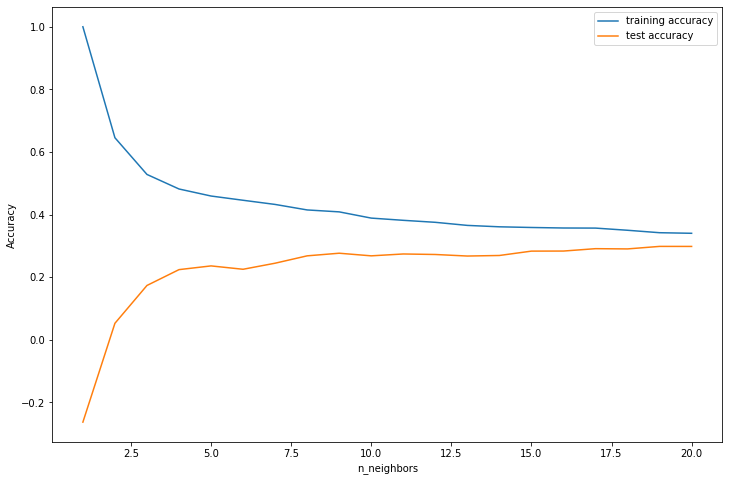

The optimal number of neighbors is: 19


In [32]:
# train/test split with the significant variables
df_data   =  df.loc[ : , candidate_dict['logit_sig']]
df_target =  df.loc[ : , 'cross_sell_success']


# train test split
X_train, X_test, y_train, y_test = train_test_split(
            df_data,
            df_target,
            random_state = 222,
            test_size    = 0.25,
            stratify     = df_target)

# determining the optimal number of neighbors
opt_neighbors = optimal_neighbors(X_data = X_train,
                                  y_data = y_train)

In [33]:
# INSTANTIATING a KNN classification model with optimal neighbors
knn_opt = KNeighborsClassifier(n_neighbors = opt_neighbors)


# FITTING the training data
knn_fit = knn_opt.fit(X_train, y_train)


# PREDICTING based on the testing set
knn_pred = knn_fit.predict(X_test)


# SCORING the results
print('Training ACCURACY:', knn_fit.score(X_train, y_train).round(4))
print('Testing  ACCURACY:', knn_fit.score(X_test, y_test).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = knn_pred).round(4))

Training ACCURACY: 0.7724
Testing  ACCURACY: 0.7187
AUC Score        : 0.6999


### KNN scaled with significant low p-value variables

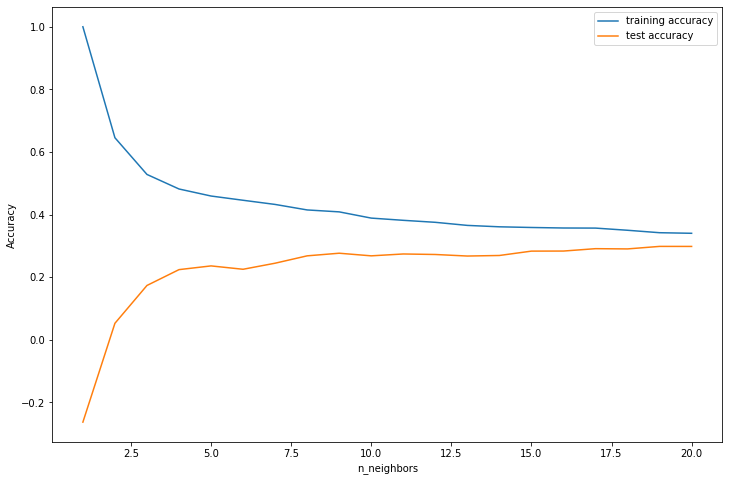

The optimal number of neighbors is: 19


In [34]:
# train/test split with the significant variables
df_data   =  df.loc[ : , candidate_dict['logit_sig']]
df_target =  df.loc[ : , 'cross_sell_success']


# train test split
X_train, X_test, y_train, y_test = train_test_split(
            df_data,
            df_target,
            random_state = 222,
            test_size    = 0.25,
            stratify     = df_target)

# determining the optimal number of neighbors
opt_neighbors = optimal_neighbors(X_data = X_train,
                                  y_data = y_train)

In [35]:
# INSTANTIATING StandardScaler()
scaler = StandardScaler()


# FITTING the data
scaler.fit(df_data)


# TRANSFORMING the data
X_scaled     = scaler.transform(df_data)


# converting to a DataFrame
X_scaled_df  = pd.DataFrame(X_scaled) 


# train-test split with the scaled data
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
            X_scaled_df,
            df_target,
            random_state = 222,
            test_size = 0.25,
            stratify = df_target)


# INSTANTIATING a KNN classification model with optimal neighbors
knn_opt = KNeighborsClassifier(n_neighbors = opt_neighbors)


# FITTING the training data
knn_fit = knn_opt.fit(X_train_scaled, y_train_scaled)


# PREDICTING based on the testing set
knn_pred = knn_fit.predict(X_test_scaled)


# SCORING the results
print('Training ACCURACY:', knn_fit.score(X_train_scaled, y_train_scaled).round(4))
print('Testing  ACCURACY:', knn_fit.score(X_test_scaled, y_test_scaled).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = knn_pred).round(4))

Training ACCURACY: 0.8067
Testing  ACCURACY: 0.7392
AUC Score        : 0.6675


### KNN scaled with all variables


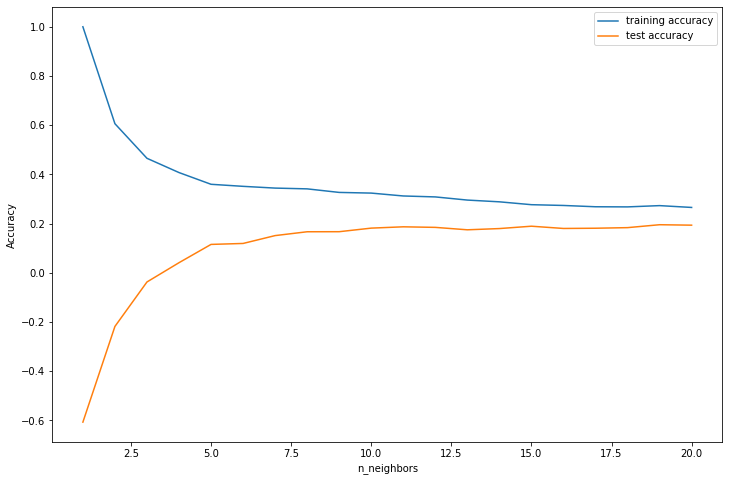

The optimal number of neighbors is: 19


In [36]:
# train/test split with full variables
df_data   =  df.loc[ : , candidate_dict['logit_full']]
df_target =  df.loc[ : , 'cross_sell_success']


# this is the exact code we were using before
X_train, X_test, y_train, y_test = train_test_split(
            df_data,
            df_target,
            random_state = 222,
            test_size    = 0.25,
            stratify     = df_target)

# determining the optimal number of neighbors
opt_neighbors = optimal_neighbors(X_data = X_train,
                                  y_data = y_train)

In [37]:
# INSTANTIATING StandardScaler()
scaler = StandardScaler()


# FITTING the data
scaler.fit(df_data)


# TRANSFORMING the data
X_scaled     = scaler.transform(df_data)


# converting to a DataFrame
X_scaled_df  = pd.DataFrame(X_scaled) 


# train-test split with the scaled data
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
            X_scaled_df,
            df_target,
            random_state = 222,
            test_size = 0.25,
            stratify = df_target)


# INSTANTIATING a KNN classification model with optimal neighbors
knn_opt = KNeighborsClassifier(n_neighbors = opt_neighbors)


# FITTING the training data
knn_fit = knn_opt.fit(X_train_scaled, y_train_scaled)


# PREDICTING based on the testing set
knn_pred = knn_fit.predict(X_test_scaled)


# SCORING the results
print('Training ACCURACY:', knn_fit.score(X_train_scaled, y_train_scaled).round(4))
print('Testing  ACCURACY:', knn_fit.score(X_test_scaled, y_test_scaled).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = knn_pred).round(4))

Training ACCURACY: 0.7649
Testing  ACCURACY: 0.7207
AUC Score        : 0.6234


### KNN with highly correlated variables

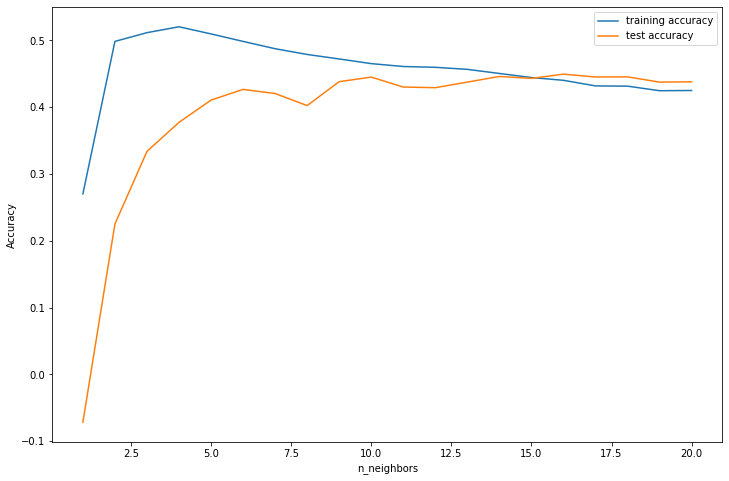

The optimal number of neighbors is: 16


In [38]:
# train/test split with high correlation variables
df_data   =  df.loc[ : , candidate_dict['high_corr']]
df_target =  df.loc[ : , 'cross_sell_success']


# this is the exact code we were using before
X_train, X_test, y_train, y_test = train_test_split(
            df_data,
            df_target,
            random_state = 222,
            test_size    = 0.25,
            stratify     = df_target)

# determining the optimal number of neighbors
opt_neighbors = optimal_neighbors(X_data = X_train,
                                  y_data = y_train)

In [39]:
# INSTANTIATING StandardScaler()
scaler = StandardScaler()


# FITTING the data
scaler.fit(df_data)


# TRANSFORMING the data
X_scaled     = scaler.transform(df_data)


# converting to a DataFrame
X_scaled_df  = pd.DataFrame(X_scaled) 


# train-test split with the scaled data
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
            X_scaled_df,
            df_target,
            random_state = 222,
            test_size = 0.25,
            stratify = df_target)


# INSTANTIATING a KNN classification model with optimal neighbors
knn_opt = KNeighborsClassifier(n_neighbors = opt_neighbors)


# FITTING the training data
knn_fit = knn_opt.fit(X_train_scaled, y_train_scaled)


# PREDICTING based on the testing set
knn_pred = knn_fit.predict(X_test_scaled)

# scaled score
# SCORING the results
print('Training ACCURACY:', knn_fit.score(X_train_scaled, y_train_scaled).round(4))
print('Testing  ACCURACY:', knn_fit.score(X_test_scaled, y_test_scaled).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = knn_pred).round(4))

Training ACCURACY: 0.8204
Testing  ACCURACY: 0.7823
AUC Score        : 0.745


In [40]:
# scoring
# train accuracy
knn_train_acc = knn_fit.score(X_train_scaled, y_train_scaled).round(4)


# test accuracy
knn_test_acc  = knn_fit.score(X_test_scaled, y_test_scaled).round(4)


# auc value
knn_auc       = roc_auc_score(y_true  = y_test_scaled,
                              y_score = knn_pred).round(4)


# saving the results
model_performance.append(['KNN high corr',
                          knn_train_acc,
                          knn_test_acc,
                          knn_auc])


In [41]:
# testing unscaled dataset
# FITTING the training data
knn_fit = knn_opt.fit(X_train, y_train)


# PREDICTING based on the testing set
knn_pred = knn_fit.predict(X_test_scaled)


# SCORING the results
print('Training ACCURACY:', knn_fit.score(X_train, y_train).round(4))
print('Testing  ACCURACY:', knn_fit.score(X_test, y_test).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = knn_pred).round(4))

Training ACCURACY: 0.8362
Testing  ACCURACY: 0.7885
AUC Score        : 0.5964


### KNN with followed_recommendations_prc only


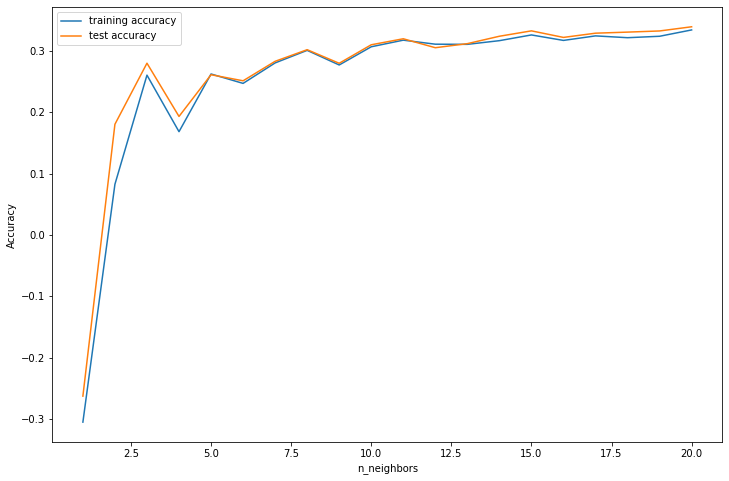

The optimal number of neighbors is: 20


In [42]:
# train/test split with followed recommendations only
df_data   =  df.loc[ : , candidate_dict['frp']]
df_target =  df.loc[ : , 'cross_sell_success']


# this is the exact code we were using before
X_train, X_test, y_train, y_test = train_test_split(
            df_data,
            df_target,
            random_state = 222,
            test_size    = 0.25,
            stratify     = df_target)

# determining the optimal number of neighbors
opt_neighbors = optimal_neighbors(X_data = X_train,
                                  y_data = y_train)

In [43]:
# INSTANTIATING StandardScaler()
scaler = StandardScaler()


# FITTING the data
scaler.fit(df_data)


# TRANSFORMING the data
X_scaled     = scaler.transform(df_data)


# converting to a DataFrame
X_scaled_df  = pd.DataFrame(X_scaled) 


# train-test split with the scaled data
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
            X_scaled_df,
            df_target,
            random_state = 222,
            test_size = 0.25,
            stratify = df_target)


# INSTANTIATING a KNN classification model with optimal neighbors
knn_opt = KNeighborsClassifier(n_neighbors = opt_neighbors)


# FITTING the training data
knn_fit = knn_opt.fit(X_train_scaled, y_train_scaled)


# PREDICTING based on the testing set
knn_pred = knn_fit.predict(X_test_scaled)


# SCORING the results
print('Training ACCURACY:', knn_fit.score(X_train_scaled, y_train_scaled).round(4))
print('Testing  ACCURACY:', knn_fit.score(X_test_scaled, y_test_scaled).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = knn_pred).round(4))

Training ACCURACY: 0.7519
Testing  ACCURACY: 0.77
AUC Score        : 0.8139


In [44]:
# train accuracy
knn_train_acc = knn_fit.score(X_train_scaled, y_train_scaled).round(4)


# test accuracy
knn_test_acc  = knn_fit.score(X_test_scaled, y_test_scaled).round(4)


# auc value
knn_auc       = roc_auc_score(y_true  = y_test_scaled,
                              y_score = knn_pred).round(4)


# saving the results
model_performance.append(['KNN FRP',
                          knn_train_acc,
                          knn_test_acc,
                          knn_auc])


### KNN Summary
KNN provided some interesting results. The highest train and test scores were achieved with the highly correlated variables. Interestingly, scaling the data increased the AUC score, but decreased the test and train scores.
By far the highest AUC score was achieved by using followed_recommendations_prc as the only variable.

## Cart Models

In [45]:
#preparing functions
# plot_feature_importances

def plot_feature_importances(model, train, export = False):
    """
    Plots the importance of features from a CART model.
    
    PARAMETERS
    ----------
    model  : CART model
    train  : explanatory variable training data
    export : whether or not to export as a .png image, default False
    """
    
    # declaring the number
    n_features = X_train.shape[1]
    
    # setting plot window
    fig, ax = plt.subplots(figsize=(12,9))
    
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(pd.np.arange(n_features), train.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    
    if export == True:
        plt.savefig('Tree_Leaf_50_Feature_Importance.png')

### Full Tree with all variables

In [46]:
# defining variable set
df_data   =  df.loc[ : , candidate_dict['logit_full']]
df_target =  df.loc[ : , 'cross_sell_success']


# train/test split 
X_train, X_test, y_train, y_test = train_test_split(
            df_data,
            df_target,
            random_state = 222,
            test_size    = 0.25,
            stratify     = df_target)


In [47]:
# INSTANTIATING a classification tree object
full_tree = DecisionTreeClassifier()


# FITTING the training data
full_tree_fit = full_tree.fit(X_train, y_train)


# PREDICTING on new data
full_tree_pred = full_tree_fit.predict(X_test)


# SCORING the model
print('Training ACCURACY:', full_tree_fit.score(X_train, y_train).round(4))
print('Testing  ACCURACY:', full_tree_fit.score(X_test, y_test).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = full_tree_pred).round(4))

Training ACCURACY: 1.0
Testing  ACCURACY: 0.7495
AUC Score        : 0.714


### Pruned Tree with all variables

In [48]:
# INSTANTIATING a classification tree object
tree_pruned      = DecisionTreeClassifier(max_depth = 8,
                                          min_samples_leaf = 25,
                                          random_state = 222)
#max_depth of 1 gives higest AUC


# FITTING the training data
tree_pruned_fit  = tree_pruned.fit(X_train, y_train)


# PREDICTING on new data
tree_pred = tree_pruned_fit.predict(X_test)


# SCORING the model
print('Training ACCURACY:', tree_pruned_fit.score(X_train, y_train).round(4))
print('Testing  ACCURACY:', tree_pruned_fit.score(X_test, y_test).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = tree_pred).round(4))



Training ACCURACY: 0.8465
Testing  ACCURACY: 0.7762
AUC Score        : 0.7405


### Pruned Tree with significant variables

In [49]:
# defining variable set
df_data   =  df.loc[ : , candidate_dict['logit_sig']]
df_target =  df.loc[ : , 'cross_sell_success']


# train/test split 
X_train, X_test, y_train, y_test = train_test_split(
            df_data,
            df_target,
            random_state = 222,
            test_size    = 0.25,
            stratify     = df_target)

# INSTANTIATING a classification tree object
tree_pruned      = DecisionTreeClassifier(max_depth = 10,
                                          min_samples_leaf = 30,
                                          random_state = 222)
#max_depth of 1 gives higest AUC


# FITTING the training data
tree_pruned_fit  = tree_pruned.fit(X_train, y_train)


# PREDICTING on new data
tree_pred = tree_pruned_fit.predict(X_test)


# SCORING the model
print('Training ACCURACY:', tree_pruned_fit.score(X_train, y_train).round(4))
print('Testing  ACCURACY:', tree_pruned_fit.score(X_test, y_test).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = tree_pred).round(4))



Training ACCURACY: 0.8341
Testing  ACCURACY: 0.7741
AUC Score        : 0.7423


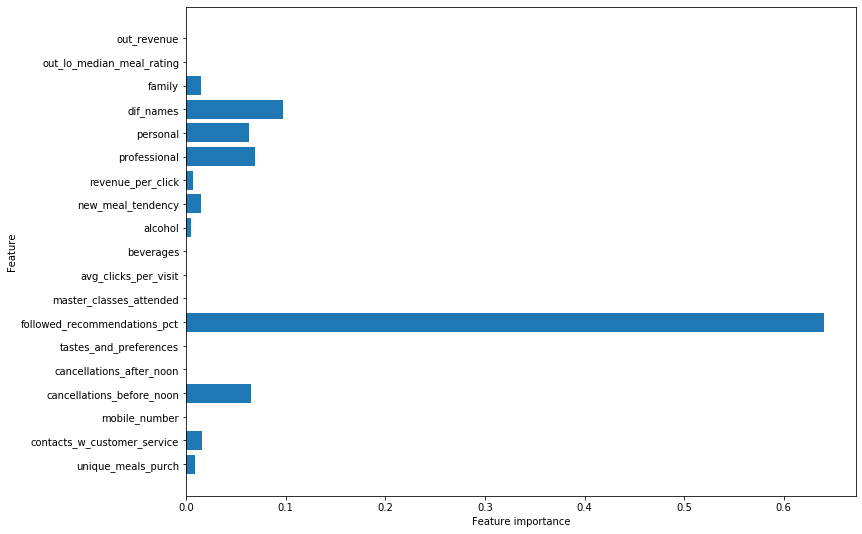

In [50]:
# plotting feature importance
plot_feature_importances(tree_pruned_fit,
                         train = X_train,
                         export = False)

### Pruned Tree with highly correlated variables

In [51]:
# defining variable set
df_data   =  df.loc[ : , candidate_dict['high_corr']]
df_target =  df.loc[ : , 'cross_sell_success']


# train/test split 
X_train, X_test, y_train, y_test = train_test_split(
            df_data,
            df_target,
            random_state = 222,
            test_size    = 0.25,
            stratify     = df_target)

# INSTANTIATING a classification tree object
tree_pruned      = DecisionTreeClassifier(max_depth = 8,
                                          min_samples_leaf = 30,
                                          random_state = 222)
#max_depth of 1 gives higest AUC


# FITTING the training data
tree_pruned_fit  = tree_pruned.fit(X_train, y_train)


# PREDICTING on new data
tree_pred = tree_pruned_fit.predict(X_test)


# SCORING the model
print('Training ACCURACY:', tree_pruned_fit.score(X_train, y_train).round(4))
print('Testing  ACCURACY:', tree_pruned_fit.score(X_test, y_test).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = tree_pred).round(4))



Training ACCURACY: 0.83
Testing  ACCURACY: 0.7967
AUC Score        : 0.7691


In [52]:
# hyperparameter tuning the above tree model
# declaring a hyperparameter space
#criterion_space = ['gini', 'entropy']
#splitter_space = ['best', 'random']
#depth_space = pd.np.arange(1, 25)
#leaf_space  = pd.np.arange(1, 100)


# creating a hyperparameter grid
#param_grid = {'criterion'        : criterion_space,
#              'splitter'         : splitter_space,
#              'max_depth'        : depth_space,
#              'min_samples_leaf' : leaf_space}


# INSTANTIATING the model object without hyperparameters
#tuned_tree = DecisionTreeClassifier(random_state = 802)


# GridSearchCV object
#tuned_tree_cv = GridSearchCV(estimator  = tuned_tree,
#                             param_grid = param_grid,
#                             cv         = 3,
#                             scoring    = make_scorer(roc_auc_score,
#                                                      needs_threshold = False))
#

# FITTING to the FULL DATASET (due to cross-validation)
#tuned_tree_cv.fit(df_data, df_target)


# PREDICT step is not needed


# printing the optimal parameters and best score
#print("Tuned Parameters  :", tuned_tree_cv.best_params_)
#print("Tuned Training AUC:", tuned_tree_cv.best_score_.round(4))

In [53]:
# tuned model
# defining variable set
df_data   =  df.loc[ : , candidate_dict['high_corr']]
df_target =  df.loc[ : , 'cross_sell_success']


# train/test split 
X_train, X_test, y_train, y_test = train_test_split(
            df_data,
            df_target,
            random_state = 222,
            test_size    = 0.25,
            stratify     = df_target)

# INSTANTIATING a classification tree object
tree_pruned      = DecisionTreeClassifier(max_depth = 12,
                                          min_samples_leaf = 4,
                                          splitter = 'random',
                                          criterion = 'entropy',
                                          random_state = 222)
# max_depth of 1 gives higest AUC


# FITTING the training data
tree_pruned_fit  = tree_pruned.fit(X_train, y_train)


# PREDICTING on new data
tree_pred = tree_pruned_fit.predict(X_test)


# SCORING the model
print('Training ACCURACY:', tree_pruned_fit.score(X_train, y_train).round(4))
print('Testing  ACCURACY:', tree_pruned_fit.score(X_test, y_test).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = tree_pred).round(4))



Training ACCURACY: 0.852
Testing  ACCURACY: 0.7823
AUC Score        : 0.7568


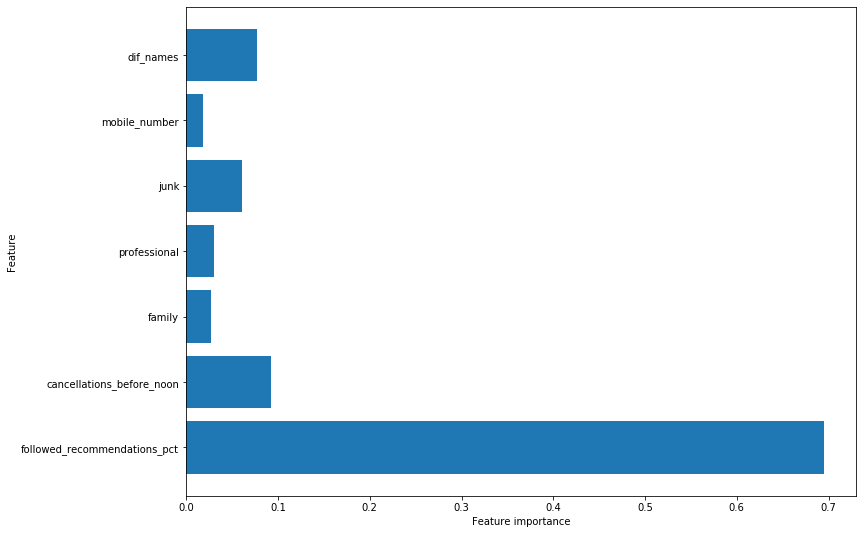

In [54]:
# plotting feature importance
plot_feature_importances(tree_pruned_fit,
                         train = X_train,
                         export = False)

In [55]:
# train accuracy
p_tree_train_acc = tree_pruned_fit.score(X_train, y_train).round(4)


# test accuracy
p_tree_test_acc  = tree_pruned_fit.score(X_test, y_test).round(4)


# auc value
p_tree_auc       = roc_auc_score(y_true  = y_test,
                                 y_score = tree_pred).round(4)


# saving the results
model_performance.append(['Tree high_corr',
                          p_tree_train_acc,
                          p_tree_test_acc,
                          p_tree_auc])

### Optimized Tree with variables significant in tree model
Starting with a full model and removing all insignificant ones, creates a new variable set with all variables relevant for Tree models.

In [56]:
# defining variable set
df_data   =  df.loc[ : , candidate_dict['tree']]
df_target =  df.loc[ : , 'cross_sell_success']


# train/test split 
X_train, X_test, y_train, y_test = train_test_split(
            df_data,
            df_target,
            random_state = 222,
            test_size    = 0.25,
            stratify     = df_target)

# INSTANTIATING a classification tree object
tree_pruned      = DecisionTreeClassifier(max_depth = 8,
                                          min_samples_leaf = 20,
                                          random_state = 222)
#max_depth of 1 gives higest AUC


# FITTING the training data
tree_pruned_fit  = tree_pruned.fit(X_train, y_train)


# PREDICTING on new data
tree_pred = tree_pruned_fit.predict(X_test)


# SCORING the model
print('Training ACCURACY:', tree_pruned_fit.score(X_train, y_train).round(4))
print('Testing  ACCURACY:', tree_pruned_fit.score(X_test, y_test).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = tree_pred).round(4))



Training ACCURACY: 0.8485
Testing  ACCURACY: 0.7659
AUC Score        : 0.7329


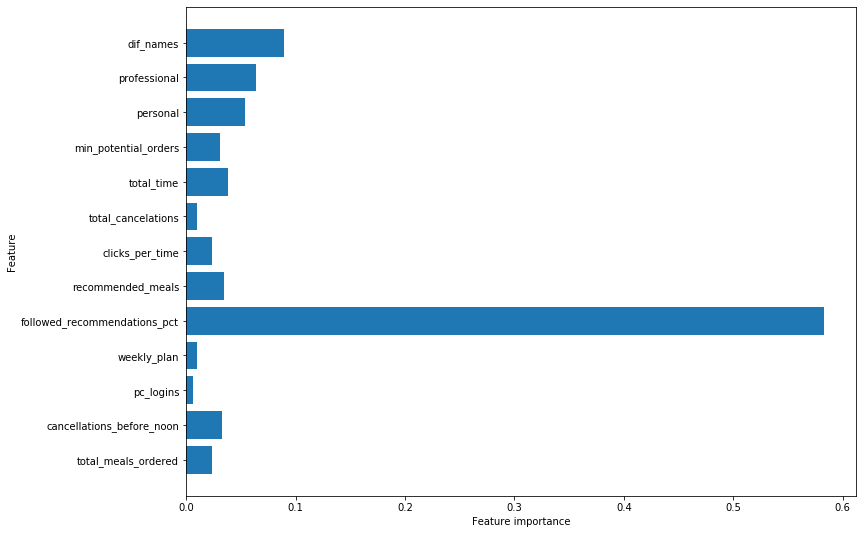

In [57]:
# plotting feature importance
plot_feature_importances(tree_pruned_fit,
                         train = X_train,
                         export = False)

In [58]:
# train accuracy
p_tree_train_acc = tree_pruned_fit.score(X_train, y_train).round(4)


# test accuracy
p_tree_test_acc  = tree_pruned_fit.score(X_test, y_test).round(4)


# auc value
p_tree_auc       = roc_auc_score(y_true  = y_test,
                                 y_score = tree_pred).round(4)


# saving the results
model_performance.append(['Tree tree',
                          p_tree_train_acc,
                          p_tree_test_acc,
                          p_tree_auc])

### Tree with followed-recommendations_prc as only variable

In [59]:
# defining variable set
df_data   =  df.loc[ : , candidate_dict['frp']]
df_target =  df.loc[ : , 'cross_sell_success']


# train/test split 
X_train, X_test, y_train, y_test = train_test_split(
            df_data,
            df_target,
            random_state = 222,
            test_size    = 0.25,
            stratify     = df_target)

# INSTANTIATING a classification tree object
tree_pruned      = DecisionTreeClassifier(max_depth = 10,
                                          min_samples_leaf = 30,
                                          random_state = 222)
#max_depth of 1 gives higest AUC


# FITTING the training data
tree_pruned_fit  = tree_pruned.fit(X_train, y_train)


# PREDICTING on new data
tree_pred = tree_pruned_fit.predict(X_test)


# SCORING the model
print('Training ACCURACY:', tree_pruned_fit.score(X_train, y_train).round(4))
print('Testing  ACCURACY:', tree_pruned_fit.score(X_test, y_test).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = tree_pred).round(4))



Training ACCURACY: 0.7519
Testing  ACCURACY: 0.77
AUC Score        : 0.8139


In [60]:
# train accuracy
p_tree_train_acc = tree_pruned_fit.score(X_train, y_train).round(4)


# test accuracy
p_tree_test_acc  = tree_pruned_fit.score(X_test, y_test).round(4)


# auc value
p_tree_auc       = roc_auc_score(y_true  = y_test,
                                 y_score = tree_pred).round(4)


# saving the results
model_performance.append(['Tree FRP',
                          p_tree_train_acc,
                          p_tree_test_acc,
                          p_tree_auc])

### Cart Model Summary
Trees are great for visualizing insights, but are often not too good at predicting. In this case, they outperformed the KNN and logistic regression models. Interestingly, the high correlation set performed better than the set optimized for trees. Again, having followed recommendations as only variable gave the highest AUC.

## Gradient boosting

### GB using all variables 

In [61]:
# gradient boosting
# defining variable set
df_data   =  df.loc[ : , candidate_dict['logit_full']]
df_target =  df.loc[ : , 'cross_sell_success']


# train/test split 
X_train, X_test, y_train, y_test = train_test_split(
            df_data,
            df_target,
            random_state = 222,
            test_size    = 0.25,
            stratify     = df_target)


GB = GradientBoostingClassifier(
                               max_depth= 1, 
                               learning_rate=0.1,
                               min_samples_leaf=20, 
                               n_estimators= 100, 
                               random_state=222)


# fitting the model

GB_fit = GB.fit(X_train, y_train)


# predicting
GB_pred = GB.predict(X_test)


# SCORING the results
print('Gradient Boosting Training Score:', GB.score(X_train, y_train).round(4))
print('Gradient Boosting Testing Score:',  GB.score(X_test, y_test).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                 y_score = GB_pred).round(4))



Gradient Boosting Training Score: 0.8307
Gradient Boosting Testing Score: 0.8214
AUC Score        : 0.7974


In [62]:
# train accuracy
GB_train_acc = GB_fit.score(X_train, y_train).round(4)


# test accuracy
GB_test_acc  = GB_fit.score(X_test, y_test).round(4)


# auc value
GB_auc       = roc_auc_score(y_true  = y_test,
                                 y_score = GB_pred).round(4)


# saving the results
model_performance.append(['Gradient Booster full',
                          GB_train_acc,
                          GB_test_acc,
                          GB_auc])


### GB using tree variables

In [63]:
#gradient boosting
# defining variable set
df_data   =  df.loc[ : , candidate_dict['tree']]
df_target =  df.loc[ : , 'cross_sell_success']


# train/test split 
X_train, X_test, y_train, y_test = train_test_split(
            df_data,
            df_target,
            random_state = 222,
            test_size    = 0.25,
            stratify     = df_target)


GB = GradientBoostingClassifier(
                               max_depth= 1, 
                               learning_rate=0.1,
                               min_samples_leaf=10, 
                               n_estimators= 50, 
                               random_state=222)


# fitting the model

GB_fit = GB.fit(X_train, y_train)


# predicting
GB_pred = GB.predict(X_test)


# SCORING the results
print('Gradient Boosting Training Score:', GB.score(X_train, y_train).round(4))
print('Gradient Boosting Testing Score:',  GB.score(X_test, y_test).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                 y_score = GB_pred).round(4))



Gradient Boosting Training Score: 0.8136
Gradient Boosting Testing Score: 0.8131
AUC Score        : 0.788


### GB with followed_recommendations_prc as only variable

In [64]:
#gradient boosting
# defining variable set
df_data   =  df.loc[ : , candidate_dict['frp']]
df_target =  df.loc[ : , 'cross_sell_success']


# train/test split 
X_train, X_test, y_train, y_test = train_test_split(
            df_data,
            df_target,
            random_state = 222,
            test_size    = 0.25,
            stratify     = df_target)


GB = GradientBoostingClassifier(
                               max_depth= 8, 
                               learning_rate=0.1,
                               min_samples_leaf=30, 
                               n_estimators= 100, 
                               random_state=222)


# fitting the model

GB_fit = GB.fit(X_train, y_train)


# predicting
GB_pred = GB.predict(X_test)


# SCORING the results
print('Gradient Boosting Training Score:', GB.score(X_train, y_train).round(4))
print('Gradient Boosting Testing Score:',  GB.score(X_test, y_test).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                 y_score = GB_pred).round(4))


Gradient Boosting Training Score: 0.7519
Gradient Boosting Testing Score: 0.77
AUC Score        : 0.8139


In [65]:
# train accuracy
GB_train_acc = GB_fit.score(X_train, y_train).round(4)


# test accuracy
GB_test_acc  = GB_fit.score(X_test, y_test).round(4)


# auc value
GB_auc       = roc_auc_score(y_true  = y_test,
                                 y_score = GB_pred).round(4)


# saving the results
model_performance.append(['Gradient Booster FRP',
                          GB_train_acc,
                          GB_test_acc,
                          GB_auc])


### Standardised full GB model

In [66]:
# testing if standardizing has a positive effect
# gradient boosting
# defining variable set
df_data   =  df.loc[ : , candidate_dict['logit_full']]
df_target =  df.loc[ : , 'cross_sell_success']


# INSTANTIATING StandardScaler()
scaler = StandardScaler()


# FITTING the data
scaler.fit(df_data)


# TRANSFORMING the data
X_scaled     = scaler.transform(df_data)


# converting to a DataFrame
X_scaled_df  = pd.DataFrame(X_scaled) 


# train-test split with the scaled data
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
            X_scaled_df,
            df_target,
            random_state = 222,
            test_size = 0.25,
            stratify = df_target)


GB = GradientBoostingClassifier(
                               max_depth= 1, 
                               learning_rate=0.1,
                               min_samples_leaf=10, 
                               n_estimators= 100, 
                               random_state=222)


# fitting the model

GB_fit = GB.fit(X_train_scaled, y_train_scaled)


# predicting
GB_pred = GB.predict(X_test_scaled)


# SCORING the results
print('Gradient Boosting Training Score:', GB.score(X_train_scaled, y_train_scaled).round(4))
print('Gradient Boosting Testing Score:',  GB.score(X_test_scaled, y_test_scaled).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test_scaled,
                                 y_score = GB_pred).round(4))



Gradient Boosting Training Score: 0.83
Gradient Boosting Testing Score: 0.8193
AUC Score        : 0.7942


In [67]:
# using hyperparameter tuning on the best GB model
# declaring a hyperparameter space
#learn_space     = pd.np.arange(0.1, 1.6, 0.3)
#estimator_space = pd.np.arange(50, 250, 50)
#depth_space     = pd.np.arange(1, 10)


# creating a hyperparameter grid
#param_grid = {'learning_rate' : learn_space,
#              'max_depth'     : depth_space,
#              'n_estimators'  : estimator_space}


# INSTANTIATING the model object without hyperparameters
#full_gbm_grid = GradientBoostingClassifier(random_state = 222)


# GridSearchCV object
#full_gbm_cv = GridSearchCV(estimator  = full_gbm_grid,
#                           param_grid = param_grid,
#                           cv         = 3,
#                           scoring    = make_scorer(roc_auc_score,
#                                        needs_threshold = False))


# FITTING to the FULL DATASET (due to cross-validation)
#full_gbm_cv.fit(df_data, df_target)


# PREDICT step is not needed


# printing the optimal parameters and best score
#print("Tuned Parameters  :", full_gbm_cv.best_params_)
#print("Tuned Training AUC:", full_gbm_cv.best_score_.round(4))

### Tuned best GB Model

In [68]:
# gradient boosting
# defining variable set
df_data   =  df.loc[ : , candidate_dict['logit_full']]
df_target =  df.loc[ : , 'cross_sell_success']


# INSTANTIATING StandardScaler()
scaler = StandardScaler()


# FITTING the data
scaler.fit(df_data)


# TRANSFORMING the data
X_scaled     = scaler.transform(df_data)


# converting to a DataFrame
X_scaled_df  = pd.DataFrame(X_scaled) 


# train-test split with the scaled data
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
            X_scaled_df,
            df_target,
            random_state = 222,
            test_size = 0.25,
            stratify = df_target)


GB = GradientBoostingClassifier(
                               max_depth= 1, 
                               learning_rate=0.1,
                               min_samples_leaf=20, 
                               n_estimators= 100, 
                               random_state=222)


# fitting the model

GB_fit = GB.fit(X_train_scaled, y_train_scaled)


# predicting
GB_pred = GB.predict(X_test_scaled)


# SCORING the results
print('Gradient Boosting Training Score:', GB.score(X_train_scaled, y_train_scaled).round(4))
print('Gradient Boosting Testing Score:',  GB.score(X_test_scaled, y_test_scaled).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test_scaled,
                                 y_score = GB_pred).round(4))



Gradient Boosting Training Score: 0.8307
Gradient Boosting Testing Score: 0.8214
AUC Score        : 0.7974


### Gradient Boosting Summary
Using all available variables in GB gave a very good result. As expected, it outperformed subsets, as GB is designed to sort out insignificant variables itself. Using appropriate hyperparameters, there was no problem with overfitting. Using followed recommendations as the only variable still scored the highest AUC score. But the full model also got a very good AUC score while having much better train and test scores. Therefore this model might even be preferred.

## Random Forest 

### RF with highly correlated variables

In [69]:
# defining variable set
df_data   =  df.loc[ : , candidate_dict['high_corr']]
df_target =  df.loc[ : , 'cross_sell_success']


# train/test split 
X_train, X_test, y_train, y_test = train_test_split(
            df_data,
            df_target,
            random_state = 222,
            test_size    = 0.25,
            stratify     = df_target)


# INSTANTIATING a random forest model with default values
rf_default = RandomForestClassifier(n_estimators     = 100,
                                    criterion        = 'gini',
                                    max_depth        = 4,
                                    min_samples_leaf = 10,
                                    bootstrap        = True,
                                    warm_start       = False,
                                    random_state     = 222)

# FITTING the training data
rf_default_fit = rf_default.fit(X_train, y_train)


# PREDICTING based on the testing set
rf_default_fit_pred = rf_default_fit.predict(X_test)


# SCORING the results
print('Training ACCURACY:', rf_default_fit.score(X_train, y_train).round(4))
print('Testing  ACCURACY:', rf_default_fit.score(X_test, y_test).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = rf_default_fit_pred).round(4))

Training ACCURACY: 0.8314
Testing  ACCURACY: 0.7906
AUC Score        : 0.7324


### Random Forest with tree variables

In [70]:
# defining variable set
df_data   =  df.loc[ : , candidate_dict['tree']]
df_target =  df.loc[ : , 'cross_sell_success']


# train/test split 
X_train, X_test, y_train, y_test = train_test_split(
            df_data,
            df_target,
            random_state = 222,
            test_size    = 0.25,
            stratify     = df_target)


# INSTANTIATING a random forest model with default values
rf_default = RandomForestClassifier(n_estimators     = 300,
                                    criterion        = 'gini',
                                    max_depth        = 4,
                                    min_samples_leaf = 4,
                                    bootstrap        = True,
                                    warm_start       = False,
                                    random_state     = 222)

# FITTING the training data
rf_default_fit = rf_default.fit(X_train, y_train)


# PREDICTING based on the testing set
rf_default_fit_pred = rf_default_fit.predict(X_test)


# SCORING the results
print('Training ACCURACY:', rf_default_fit.score(X_train, y_train).round(4))
print('Testing  ACCURACY:', rf_default_fit.score(X_test, y_test).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = rf_default_fit_pred).round(4))

Training ACCURACY: 0.841
Testing  ACCURACY: 0.8111
AUC Score        : 0.7644


In [71]:
#plot_feature_importances(model = rf_default_fit, train=X_train)

### RF with followed recommendations as only variable

In [72]:
# defining variable set
df_data   =  df.loc[ : , candidate_dict['frp']]
df_target =  df.loc[ : , 'cross_sell_success']


# train/test split 
X_train, X_test, y_train, y_test = train_test_split(
            df_data,
            df_target,
            random_state = 222,
            test_size    = 0.25,
            stratify     = df_target)


# INSTANTIATING a random forest model with default values
rf_default = RandomForestClassifier(n_estimators     = 300,
                                    criterion        = 'gini',
                                    max_depth        = 4,
                                    min_samples_leaf = 4,
                                    bootstrap        = True,
                                    warm_start       = False,
                                    random_state     = 222)

# FITTING the training data
rf_default_fit = rf_default.fit(X_train, y_train)


# PREDICTING based on the testing set
rf_default_fit_pred = rf_default_fit.predict(X_test)


# SCORING the results
print('Training ACCURACY:', rf_default_fit.score(X_train, y_train).round(4))
print('Testing  ACCURACY:', rf_default_fit.score(X_test, y_test).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = rf_default_fit_pred).round(4))

Training ACCURACY: 0.7519
Testing  ACCURACY: 0.77
AUC Score        : 0.8139


In [73]:
# train accuracy
RF_train_acc = rf_default_fit.score(X_train, y_train).round(4)


# test accuracy
RF_test_acc  = rf_default_fit.score(X_test, y_test).round(4)


# auc value
RF_auc       = roc_auc_score(y_true  = y_test,
                                          y_score = rf_default_fit_pred).round(4)


# saving the results
model_performance.append(['Random Forest FRP',
                          RF_train_acc,
                          RF_test_acc,
                          RF_auc])


### RF with full variable Set
Used as starting point to optimize a specialized RF set

In [74]:
# defining variable set
df_data   =  df.loc[ : , candidate_dict['logit_full']]
df_target =  df.loc[ : , 'cross_sell_success']


# train/test split 
X_train, X_test, y_train, y_test = train_test_split(
            df_data,
            df_target,
            random_state = 222,
            test_size    = 0.25,
            stratify     = df_target)


# INSTANTIATING a random forest model with default values
rf_default = RandomForestClassifier(n_estimators     = 300,
                                    criterion        = 'gini',
                                    max_depth        = 4,
                                    min_samples_leaf = 4,
                                    bootstrap        = True,
                                    warm_start       = False,
                                    random_state     = 222)

# FITTING the training data
rf_default_fit = rf_default.fit(X_train, y_train)


# PREDICTING based on the testing set
rf_default_fit_pred = rf_default_fit.predict(X_test)


# SCORING the results
print('Training ACCURACY:', rf_default_fit.score(X_train, y_train).round(4))
print('Testing  ACCURACY:', rf_default_fit.score(X_test, y_test).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = rf_default_fit_pred).round(4))

Training ACCURACY: 0.8424
Testing  ACCURACY: 0.7906
AUC Score        : 0.7256


### RF with all variables relevant for RF

In [75]:
# defining variable set
df_data   =  df.loc[ : , candidate_dict['RF']]
df_target =  df.loc[ : , 'cross_sell_success']


# train/test split 
X_train, X_test, y_train, y_test = train_test_split(
            df_data,
            df_target,
            random_state = 222,
            test_size    = 0.25,
            stratify     = df_target)


# INSTANTIATING a random forest model with default values
rf_default = RandomForestClassifier(n_estimators     = 300,
                                    criterion        = 'gini',
                                    max_depth        = 4,
                                    min_samples_leaf = 4,
                                    bootstrap        = True,
                                    warm_start       = False,
                                    random_state     = 222)

# FITTING the training data
rf_default_fit = rf_default.fit(X_train, y_train)


# PREDICTING based on the testing set
rf_default_fit_pred = rf_default_fit.predict(X_test)


# SCORING the results
print('Training ACCURACY:', rf_default_fit.score(X_train, y_train).round(4))
print('Testing  ACCURACY:', rf_default_fit.score(X_test, y_test).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = rf_default_fit_pred).round(4))

Training ACCURACY: 0.8458
Testing  ACCURACY: 0.8029
AUC Score        : 0.7584


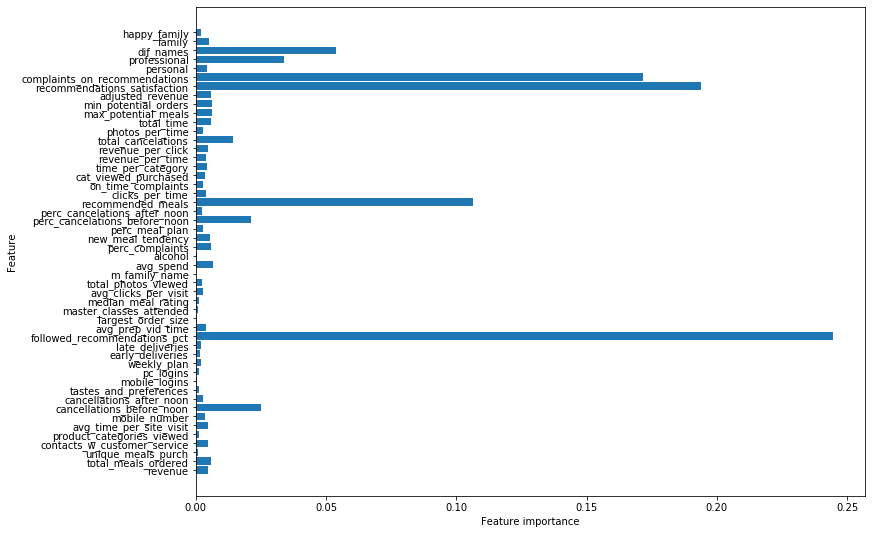

In [76]:
plot_feature_importances(model = rf_default_fit, train=X_train)

### RF with specialized lean RF variable set

In [77]:
# defining variable set
df_data   =  df.loc[ : , candidate_dict['RF_lean']]
df_target =  df.loc[ : , 'cross_sell_success']


# train/test split 
X_train, X_test, y_train, y_test = train_test_split(
            df_data,
            df_target,
            random_state = 222,
            test_size    = 0.25,
            stratify     = df_target)


# INSTANTIATING a random forest model with default values
rf_default = RandomForestClassifier(n_estimators     = 100,
                                    criterion        = 'gini',
                                    max_depth        = 8,
                                    min_samples_leaf = 10,
                                    bootstrap        = True,
                                    warm_start       = False,
                                    random_state     = 222)

# FITTING the training data
rf_default_fit = rf_default.fit(X_train, y_train)


# PREDICTING based on the testing set
rf_default_fit_pred = rf_default_fit.predict(X_test)


# SCORING the results
print('Training ACCURACY:', rf_default_fit.score(X_train, y_train).round(4))
print('Testing  ACCURACY:', rf_default_fit.score(X_test, y_test).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = rf_default_fit_pred).round(4))

Training ACCURACY: 0.7992
Testing  ACCURACY: 0.8049
AUC Score        : 0.8107


In [78]:
#plot_feature_importances(model = rf_default_fit, train=X_train)

### RF lean optimized with hyperparameter tuning

In [79]:
#hyperparameter tuning the best, i.e. the lean model

# declaring a hyperparameter space
#estimator_space  = pd.np.arange(100, 1100, 250)
#leaf_space       = pd.np.arange(1, 31, 10)
#criterion_space  = ['gini', 'entropy']
#bootstrap_space  = [True, False]
#warm_start_space = [True, False]


# creating a hyperparameter grid
#param_grid = {'n_estimators'     : estimator_space,
#              'min_samples_leaf' : leaf_space,
#              'criterion'        : criterion_space,
#              'bootstrap'        : bootstrap_space,
#              'warm_start'       : warm_start_space}


# INSTANTIATING the model object without hyperparameters
#full_forest_grid = RandomForestClassifier(random_state = 222)


# GridSearchCV object
#full_forest_cv = GridSearchCV(estimator  = full_forest_grid,
#                              param_grid = param_grid,
#                              cv         = 3,
#                              scoring    = make_scorer(roc_auc_score,
#                                           needs_threshold = False))


# FITTING to the FULL DATASET (due to cross-validation)
#full_forest_cv.fit(df_data, df_target)


# PREDICT step is not needed


# printing the optimal parameters and best score
#print("Tuned Parameters  :", full_forest_cv.best_params_)
#print("Tuned Training AUC:", full_forest_cv.best_score_.round(4))

In [80]:
#inputting optimal hyperparameters
# defining variable set
df_data   =  df.loc[ : , candidate_dict['RF_lean']]
df_target =  df.loc[ : , 'cross_sell_success']


# train/test split 
X_train, X_test, y_train, y_test = train_test_split(
            df_data,
            df_target,
            random_state = 222,
            test_size    = 0.25,
            stratify     = df_target)


# INSTANTIATING a random forest model with default values
rf_default = RandomForestClassifier(n_estimators     = 100,
                                    criterion        = 'gini',
                                    max_depth        = 8,
                                    min_samples_leaf = 1,
                                    bootstrap        = True,
                                    warm_start       = True,
                                    random_state     = 222)

# FITTING the training data
rf_default_fit = rf_default.fit(X_train, y_train)


# PREDICTING based on the testing set
rf_default_fit_pred = rf_default_fit.predict(X_test)


# SCORING the results
print('Training ACCURACY:', rf_default_fit.score(X_train, y_train).round(4))
print('Testing  ACCURACY:', rf_default_fit.score(X_test, y_test).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = rf_default_fit_pred).round(4))

Training ACCURACY: 0.8005
Testing  ACCURACY: 0.8111
AUC Score        : 0.8187


In [81]:
# train accuracy
RF_train_acc = rf_default_fit.score(X_train, y_train).round(4)


# test accuracy
RF_test_acc  = rf_default_fit.score(X_test, y_test).round(4)


# auc value
RF_auc       = roc_auc_score(y_true  = y_test,
                                          y_score = rf_default_fit_pred).round(4)


# saving the results
model_performance.append(['Random Forest Optimal',
                          RF_train_acc,
                          RF_test_acc,
                          RF_auc])


In [82]:
# checking the confusion matrix
print(confusion_matrix(y_true = y_test,
                       y_pred = rf_default_fit_pred))

[[131  25]
 [ 67 264]]


### RF maximized for test score

In [83]:
#inputting optimal hyperparameters
# defining variable set
df_data   =  df.loc[ : , candidate_dict['RF_max_test']]
df_target =  df.loc[ : , 'cross_sell_success']


# train/test split 
X_train, X_test, y_train, y_test = train_test_split(
            df_data,
            df_target,
            random_state = 222,
            test_size    = 0.25,
            stratify     = df_target)


# INSTANTIATING a random forest model with default values
rf_default = RandomForestClassifier(n_estimators     = 100,
                                    criterion        = 'gini',
                                    max_depth        = 8,
                                    min_samples_leaf = 1,
                                    bootstrap        = True,
                                    warm_start       = True,
                                    random_state     = 222)

# FITTING the training data
rf_default_fit = rf_default.fit(X_train, y_train)


# PREDICTING based on the testing set
rf_default_fit_pred = rf_default_fit.predict(X_test)


# SCORING the results
print('Training ACCURACY:', rf_default_fit.score(X_train, y_train).round(4))
print('Testing  ACCURACY:', rf_default_fit.score(X_test, y_test).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = rf_default_fit_pred).round(4))

Training ACCURACY: 0.8019
Testing  ACCURACY: 0.8214
AUC Score        : 0.8177


In [84]:
# train accuracy
RF_train_acc = rf_default_fit.score(X_train, y_train).round(4)


# test accuracy
RF_test_acc  = rf_default_fit.score(X_test, y_test).round(4)


# auc value
RF_auc       = roc_auc_score(y_true  = y_test,
                                          y_score = rf_default_fit_pred).round(4)


# saving the results
model_performance.append(['Random Forest Max Test',
                          RF_train_acc,
                          RF_test_acc,
                          RF_auc])


In [85]:
# checking the confusion matrix
print(confusion_matrix(y_true = y_test,
                       y_pred = rf_default_fit_pred))

[[126  30]
 [ 57 274]]


# Final Model
The lean and optimized Random Forest model was finally able to beat followed_recommendations_prc as the only variable. There where two almost identical models. One has as slightly higher AUC, but the other one has a significantly higher test score. Looking at the confusion matrices, the higher AUC score was better at predicting success. It had a higher number of true positives at the expense of also having more false positives. The other model had more true negatives, but also more false negatives and is generally better at predicting unsuccessful cases. For this use case, false positives mean lost customers and are much worse than false positives, which just indicate unsuccessful leads. Therefore, the higher AUC score model is to be preferred. 

In [86]:
# defining variable set
df_data   =  df.loc[ : , candidate_dict['RF_lean']]
df_target =  df.loc[ : , 'cross_sell_success']


# train/test split 
X_train, X_test, y_train, y_test = train_test_split(
            df_data,
            df_target,
            random_state = 222,
            test_size    = 0.25,
            stratify     = df_target)


# INSTANTIATING a random forest model with default values
rf_default = RandomForestClassifier(n_estimators     = 100,
                                    criterion        = 'gini',
                                    max_depth        = 8,
                                    min_samples_leaf = 1,
                                    bootstrap        = True,
                                    warm_start       = True,
                                    random_state     = 222)

# FITTING the training data
rf_default_fit = rf_default.fit(X_train, y_train)


# PREDICTING based on the testing set
rf_default_fit_pred = rf_default_fit.predict(X_test)


# SCORING the results
print('Training ACCURACY:', rf_default_fit.score(X_train, y_train).round(4))
print('Testing  ACCURACY:', rf_default_fit.score(X_test, y_test).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = rf_default_fit_pred).round(4))

Training ACCURACY: 0.8005
Testing  ACCURACY: 0.8111
AUC Score        : 0.8187


In [87]:
# train accuracy
RF_train_acc = rf_default_fit.score(X_train, y_train).round(4)


# test accuracy
RF_test_acc  = rf_default_fit.score(X_test, y_test).round(4)


# auc value
RF_auc       = roc_auc_score(y_true  = y_test,
                                          y_score = rf_default_fit_pred).round(4)


# saving the results
model_performance.append(['Final Model',
                          RF_train_acc,
                          RF_test_acc,
                          RF_auc])


# Additional Investigations on Final Model

In [88]:
# checking the confusion matrix
#print(confusion_matrix(y_true = y_test,
#                       y_pred = rf_default_fit_pred))
#precision=(131)/(131+67)
#print(precision)

Our final model has very little false negatives, but a relatively large number of false positives. This means we are quite good at predicting who will definitely not sign up, but less good in predicting who will sign up. In the context of halfway there this is a comfortable position to be in. It means, we loose very few customers because we predict predict them to not sign up. On the flip side, a good number of our positive predictions, which would be our leads for our sales team do not convert. This causes some costs in inefficient marketing. But if given the choice, we would rather try a few leads more then loose out on future customers. 
With these characteristics the model can be used as a sales tool. Positive predictions would be our sales leads to follow up on. Based on our precision, two thirds of our leads will lead to a conversion. 
Since followed_recommedations_pct is by far the most important variable, it should be investigated further. It seams to be correlated with variables engineered on the basis of names and name frequencies. This can indicate peer to peer recommendation and can be used for marketing purposes.

In [89]:
#df_corr=df.corr()
#print(df_corr.loc['followed_recommendations_pct'].sort_values(ascending = False))

# Final Scoring

In [90]:
# converting to DataFrame and checking the results
pd.DataFrame(model_performance[1:], columns = model_performance[0])

,Model,Training Accuracy,Testing Accuracy,AUC Value
0,Logistic Regression Full,0.6936,0.6961,0.6375
1,Logistic Regression Sig,0.8012,0.7577,0.7167
2,KNN high corr,0.8204,0.7823,0.7450
3,KNN FRP,0.7519,0.7700,0.8139
4,Tree high_corr,0.8520,0.7823,0.7568
5,Tree tree,0.8485,0.7659,0.7329
6,Tree FRP,0.7519,0.7700,0.8139
7,Gradient Booster full,0.8307,0.8214,0.7974
8,Gradient Booster FRP,0.7519,0.7700,0.8139
9,Random Forest FRP,0.7519,0.7700,0.8139
